In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

import utils_data

In [8]:
# Choose dataset to use
# For the MNIST dataset, we use the default torchvision data loader
# For YaleB Face dataset, download the data .zip and put it in the ./data folder.

DATASET = 'MNIST'
# DATASET = 'YALEB'

X_all, y_all = utils_data.load_dataset(name=DATASET, root='./data')
X_all.shape

torch.Size([60000, 784])

Number of samples: 60000


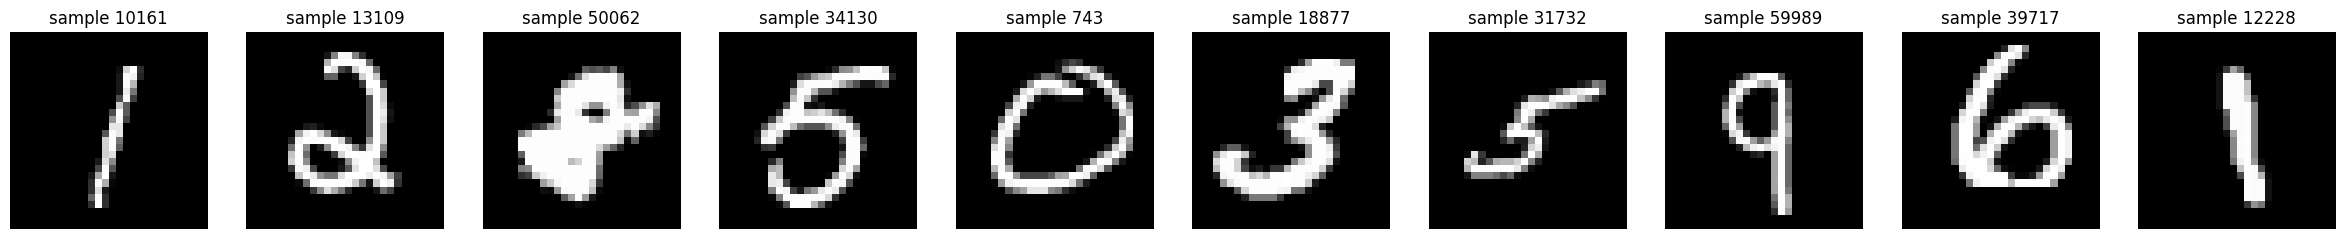

In [12]:
def filter_classes_or_individuals(classes):
    samples = []
    for c in classes:
        samples.append(X_all[y_all==c])
    return torch.vstack(samples)


## Filter out classes or individuals
## MNIST: Class 0 - 9
## YALEB: Class 1 - 38
CLASSES = range(10) # MODIFY THIS LINE
X = filter_classes_or_individuals(CLASSES)


# Visualize Samples
print(f'Number of samples: {X.shape[0]}')
sample_idxs = np.random.choice(X.shape[0], 10, replace=False)
fig, ax = plt.subplots(ncols=10, figsize=(30, 5))
for i, sample_idx in enumerate(sample_idxs):
    ax[i].imshow(X[sample_idx].reshape(28, 28), cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'sample {sample_idx}')
plt.show()

## Part (a): Closed-form PPCA
Implement functions that compute the sample mean and covariance and return the closed-form PPCA estimates $(W^*, b^*, \sigma^*)$ given $X$ and latent dimension $d$. Use the formulas from class.

torch.Size([784]) torch.Size([784, 784])


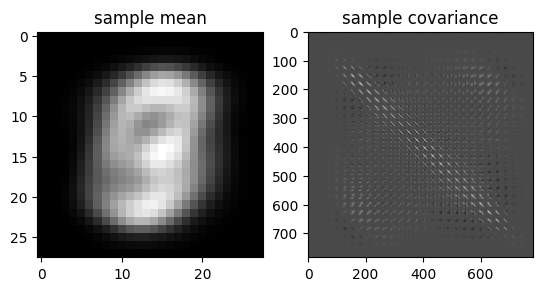

In [59]:
# Closed-form PPCA helpers
n_samples, data_dim = X.shape

def compute_sample_mean_cov(X: torch.Tensor):
    # X: [N, D]
    mean = torch.mean(X, dim=0)
    cov = torch.t(X - mean) @ (X - mean) / X.shape[0]
    return mean, cov

# implement closed-form PPCA (return W_star, b_star, sigma_star)
def closed_form_ppca(X: torch.Tensor, d: int):
    mean, cov = compute_sample_mean_cov(X)
    b_star = mean
    
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    lambda_1 = eigenvalues[:d]  # Top d eigenvalues
    U_1 = eigenvectors[:, :d]   # Top d eigenvectors
    
    # Compute sigma_star^2 = (1/(D-d)) * sum of remaining eigenvalues
    D = X.shape[1]
    remaining_eigenvalues = eigenvalues[d:]  # eigenvalues from d+1 to D
    sigma_squared = torch.mean(remaining_eigenvalues)
    sigma_star = torch.sqrt(sigma_squared)
    
    # Compute W_star = U_1 * (Lambda_1 - sigma^2 * I)^(1/2) * R
    # for simplicity, set R = I
    Lambda_1_minus_sigma_squared_I = torch.diag(lambda_1 - sigma_squared)
    sqrt_term = torch.sqrt(Lambda_1_minus_sigma_squared_I)
    W_star = U_1 @ sqrt_term

    return W_star, b_star, sigma_star

# quick visualization of sample stats
sample_mean, sample_covariance = compute_sample_mean_cov(X)
print(sample_mean.shape, sample_covariance.shape)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(sample_mean.view(28, 28).numpy(), cmap='gray')
ax[0].set_title('sample mean')
ax[1].imshow(sample_covariance.numpy(), cmap='gray')
ax[1].set_title('sample covariance')
plt.show()

W_star shape: torch.Size([784, 10])
b_star shape: torch.Size([784])
sigma_star value: 0.373456
Expected W_star shape: (784, 10)
Actual W_star shape: torch.Size([784, 10])
sigma_star is positive: True


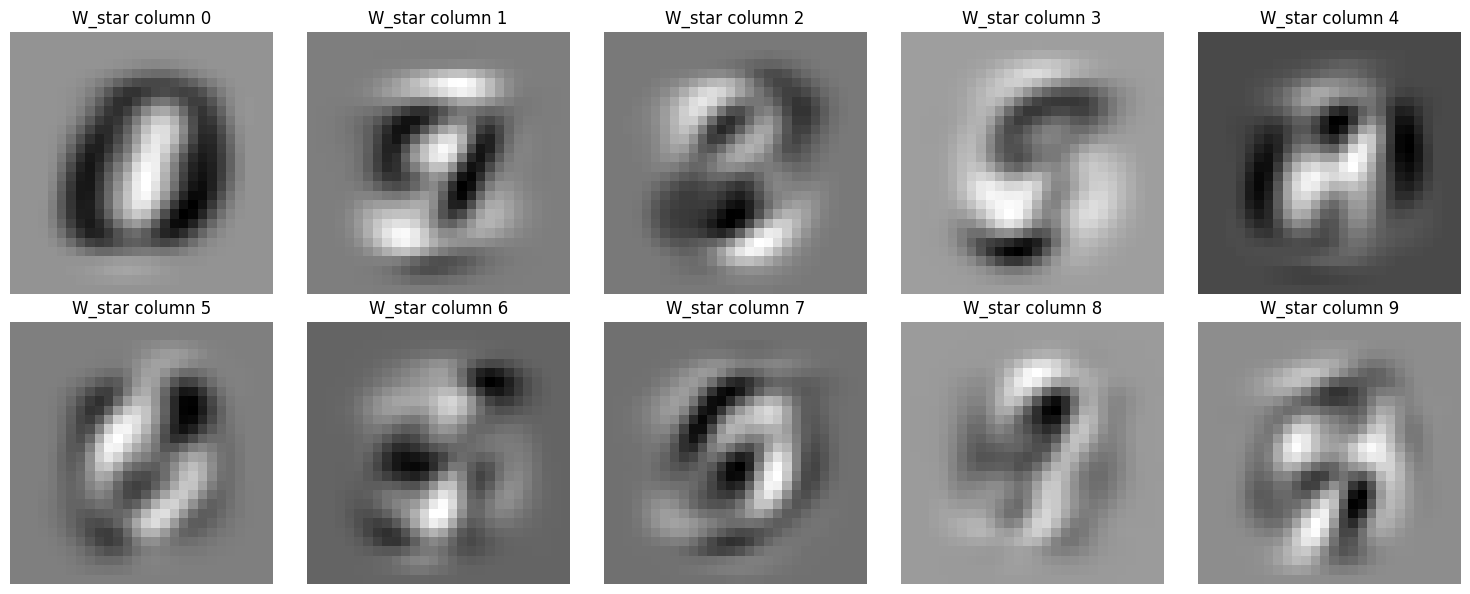

In [60]:
# Test the corrected closed-form PPCA implementation
latent_dim = 10
W_star, b_star, sigma_star = closed_form_ppca(X, latent_dim)

print(f"W_star shape: {W_star.shape}")
print(f"b_star shape: {b_star.shape}")
print(f"sigma_star value: {sigma_star:.6f}")

# Verify that W_star has the correct dimensions
print(f"Expected W_star shape: ({data_dim}, {latent_dim})")
print(f"Actual W_star shape: {W_star.shape}")

# Check that sigma_star is positive
print(f"sigma_star is positive: {sigma_star > 0}")

# Visualize the first few columns of W_star as images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i in range(min(10, latent_dim)):
    axes[i].imshow(W_star[:, i].view(28, 28).numpy(), cmap='gray')
    axes[i].set_title(f'W_star column {i}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## Part (b): EM for PPCA
Implement one EM iteration mapping $(b^k, W^k, \sigma^k)$ to $(b^{k+1}, W^{k+1}, \sigma^{k+1})$ using your analytical formulas. Initialize with $b^0 = 0$, $W^0 =$ `first d columns of I_D`, $\sigma^0 = 0.1$. Record the data log-likelihood per iteration for later plotting.

In [62]:
# EM for PPCA scaffold
latent_dim = 10

# initialization is done for you
b_k = torch.zeros(data_dim)
W_k = torch.eye(data_dim)[:, :latent_dim].contiguous()
sigma_k = torch.tensor(0.1)

# implement E-step helper that returns Ez (Nxd) and EzzT (dxd)
def estep_posterior_moments(X: torch.Tensor, b: torch.Tensor, W: torch.Tensor, sigma: torch.Tensor):
    """
        Ez: [N, d] posterior means E[z_j | x_j] for each sample
        EzzT: [d, d] posterior second moment E[z_j z_j^T | x_j] (same for all samples)
    """
    N, D = X.shape
    d = W.shape[1]
    
    WtW = W.T @ W  # [d, d]
    sigma_squared = sigma**2
    Sigma_zx_inv = WtW + sigma_squared * torch.eye(d)  # [d, d]
    Sigma_zx = sigma_squared * torch.linalg.inv(Sigma_zx_inv)
    X_centered = X - b.unsqueeze(0)  # [N, D]
    Ez = X_centered @ W @ torch.linalg.inv(Sigma_zx_inv)  # [N, d]

    EzzT = Sigma_zx + (1/N) * (Ez.T @ Ez)  # [d, d]
    
    return Ez, EzzT

# implement M-step update
def mstep_update(X: torch.Tensor, Ez: torch.Tensor, EzzT: torch.Tensor):
    N, D = X.shape
    d = Ez.shape[1]
    
    # Compute b_next = (1/N) * sum_j x_j (ML estimator)
    b_next = torch.mean(X, dim=0)
    
    # Compute W_next using the formula from the problem statement
    # W^{k+1} = (sum_j (x_j - b_hat) (z_j)^k^T) * (sum_j (z_j z_j^T)^k)^(-1)
    X_centered = X - b_next.unsqueeze(0)  # [N, D]
    
    # sum_j (x_j - b_hat) (z_j)^k^T = X_centered^T @ Ez
    numerator = X_centered.T @ Ez  # [D, d]
    
    # sum_j (z_j z_j^T)^k = N * EzzT (since EzzT is averaged over samples)
    denominator = N * EzzT  # [d, d]
    
    W_next = numerator @ torch.linalg.inv(denominator)  # [D, d]
    
    # Compute sigma_next using the formula from the problem statement
    # sigma^{k+1} = sqrt((1/(ND)) * sum_j (||x_j - b_hat||^2 - 2(x_j - b_hat)^T W^{k+1} (z_j)^k + trace(W^{k+1}^T W^{k+1} (z_j z_j^T)^k)))
    
    # ||x_j - b_hat||^2 for all j
    norm_squared = torch.sum(X_centered**2, dim=1)  # [N]
    
    # 2(x_j - b_hat)^T W^{k+1} (z_j)^k for all j
    linear_term = 2 * torch.sum(X_centered @ W_next * Ez, dim=1)  # [N]
    
    # trace(W^{k+1}^T W^{k+1} (z_j z_j^T)^k) for all j
    # Since (z_j z_j^T)^k is the same for all j, this becomes:
    trace_term = torch.trace(W_next.T @ W_next @ EzzT)  # scalar
    
    # Sum over all samples
    total_sum = torch.sum(norm_squared - linear_term) + N * trace_term
    
    sigma_squared_next = total_sum / (N * D)
    sigma_next = torch.sqrt(sigma_squared_next)
    
    return b_next, W_next, sigma_next

# compute log-likelihood 
def log_likelihood(X: torch.Tensor, b: torch.Tensor, W: torch.Tensor, sigma: torch.Tensor):
    N, D = X.shape
    d = W.shape[1]

    # Add small jitter for numerical stability
    jitter = 1e-6
    Cov_x = W @ W.T + (sigma**2 + jitter) * torch.eye(D)
    X_centered = X - b.unsqueeze(0)  # [N, D]
    
    # For numerical stability, use Cholesky decomposition with error handling
    try:
        L = torch.linalg.cholesky(Cov_x)  # Cov_x = L L^T
        log_det = 2 * torch.sum(torch.log(torch.diag(L)))  # log det(Cov_x)
        
        # Solve L y = x_j - b for each j
        y = torch.linalg.solve_triangular(L, X_centered.T, upper=False)  # [D, N]
        quad_form = torch.sum(y**2, dim=0)  # [N] - quadratic form (x_j - b)^T Cov_x^{-1} (x_j - b)
    except Exception as e:
        # If Cholesky fails, use eigenvalue decomposition (slower but more robust)
        eigenvalues, eigenvectors = torch.linalg.eigh(Cov_x)
        eigenvalues = torch.clamp(eigenvalues, min=jitter)  # Ensure positive
        log_det = torch.sum(torch.log(eigenvalues))
        
        # Compute inverse using eigenvalue decomposition
        Cov_x_inv = eigenvectors @ torch.diag(1.0 / eigenvalues) @ eigenvectors.T
        quad_form = torch.sum(X_centered @ Cov_x_inv * X_centered, dim=1)  # [N]
    
    # Log-likelihood for each sample
    log_likelihood_per_sample = -0.5 * (D * torch.log(torch.tensor(2 * torch.pi)) + log_det + quad_form)
    
    # Total log-likelihood
    ll = torch.sum(log_likelihood_per_sample)
    
    return ll

In [33]:
# Test the E-step implementation
print("Testing E-step implementation...")

# Test with the initialized parameters
Ez, EzzT = estep_posterior_moments(X, b_k, W_k, sigma_k)

print(f"Ez shape: {Ez.shape}")
print(f"EzzT shape: {EzzT.shape}")
print(f"Expected Ez shape: ({X.shape[0]}, {latent_dim})")
print(f"Expected EzzT shape: ({latent_dim}, {latent_dim})")

# Check that EzzT is symmetric and positive definite
print(f"EzzT is symmetric: {torch.allclose(EzzT, EzzT.T)}")
print(f"EzzT eigenvalues (should be positive): {torch.linalg.eigvals(EzzT).real}")

# Test one EM iteration
print("\nTesting one EM iteration...")
b_next, W_next, sigma_next = mstep_update(X, Ez, EzzT)

print(f"b_next shape: {b_next.shape}")
print(f"W_next shape: {W_next.shape}")
print(f"sigma_next value: {sigma_next:.6f}")

# Test log-likelihood computation
ll_initial = log_likelihood(X, b_k, W_k, sigma_k)
ll_after_one_iter = log_likelihood(X, b_next, W_next, sigma_next)

print(f"Initial log-likelihood: {ll_initial:.2f}")
print(f"Log-likelihood after one EM iteration: {ll_after_one_iter:.2f}")
print(f"Log-likelihood improved: {ll_after_one_iter > ll_initial}")


Testing E-step implementation...
Ez shape: torch.Size([60000, 10])
EzzT shape: torch.Size([10, 10])
Expected Ez shape: (60000, 10)
Expected EzzT shape: (10, 10)
EzzT is symmetric: True
EzzT eigenvalues (should be positive): tensor([0.0099, 9.8128, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
        0.0099])

Testing one EM iteration...
b_next shape: torch.Size([784])
W_next shape: torch.Size([784, 10])
sigma_next value: 0.518657
Initial log-likelihood: -2083061248.00
Log-likelihood after one EM iteration: -35864540.00
Log-likelihood improved: True


## Part (c): Gradient ascent for the PPCA ELBO
Implement gradient ascent on the PPCA ELBO with respect to $(W, b, \sigma)$ and, if optimizing jointly, the variational parameters $(A, c, \Sigma_e)$ using the gradients from the analytical section. Try multiple step sizes and record the objective per iteration for later comparison.

Running gradient ascent on PPCA ELBO...
Iteration 0: ELBO = 1093382.25, Log-likelihood = -2083143552.00
Iteration 10: ELBO = 1094948.12, Log-likelihood = -2045336960.00
Iteration 20: ELBO = 1096869.38, Log-likelihood = -1982629632.00
Iteration 30: ELBO = 1099216.12, Log-likelihood = -1893169792.00
Iteration 40: ELBO = 1101989.00, Log-likelihood = -1780327808.00
Iteration 50: ELBO = 1105071.88, Log-likelihood = -1653369088.00
Iteration 60: ELBO = 1108257.38, Log-likelihood = -1523171328.00
Iteration 70: ELBO = 1111325.75, Log-likelihood = -1399167104.00
Iteration 80: ELBO = 1114139.12, Log-likelihood = -1287849472.00
Iteration 90: ELBO = 1116665.75, Log-likelihood = -1192337408.00
Iteration 100: ELBO = 1118924.62, Log-likelihood = -1112729088.00
Iteration 110: ELBO = 1120947.25, Log-likelihood = -1047177920.00
Iteration 120: ELBO = 1122774.75, Log-likelihood = -993193984.00
Iteration 130: ELBO = 1124444.38, Log-likelihood = -948479616.00
Iteration 140: ELBO = 1125988.38, Log-likelihood 

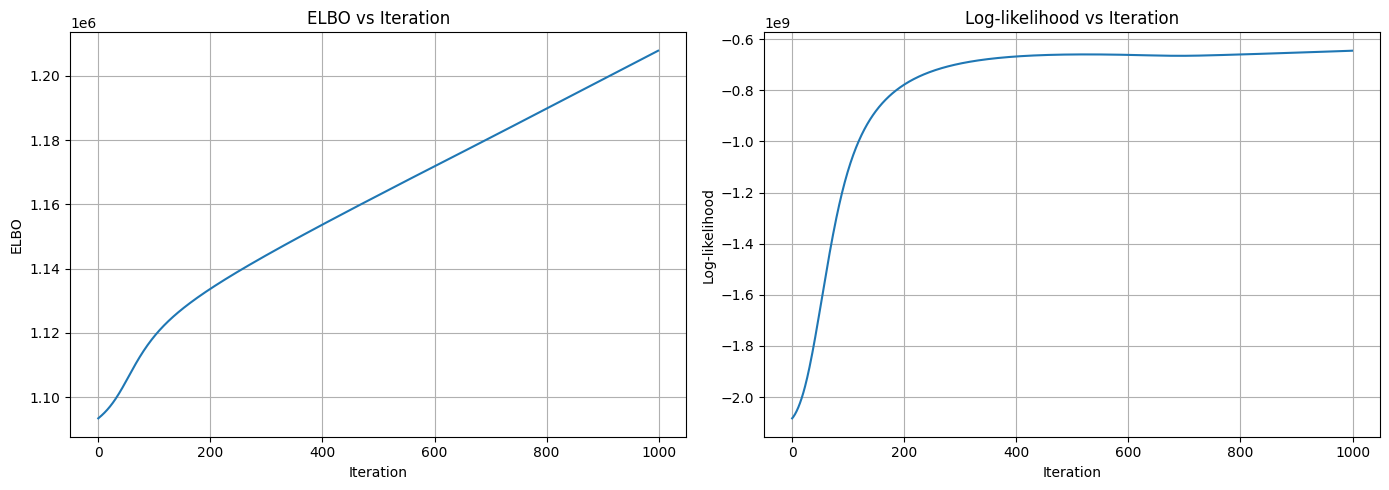


Final ELBO: 1207829.50
Final Log-likelihood: -645502208.00


In [51]:
# ELBO gradient ascent 

def compute_elbo(X, W, b, sigma, A, c, Sigma_e):
    """
    Compute the ELBO for PPCA model with variational parameters.
    
    Based on Equation (17) from the problem:
    L(q,θ) = N(d/2 log(e/(2π)) + 1/2 log(|Σe|/σ^2d) - 1/(2σ^2)(trace(ΣN) + ||μN - b||²))
             - 1/(2σ²)⟨σ²I + W^⊤W, Σe + AΣNᴬ^⊤ + (AμN + c)(AμN + c)^⊤⟩
             - 1/σ²⟨W^⊤(μN - b), AμN + c⟩ - 1/σ²⟨ΣN, WA⟩
    """
    N, D = X.shape
    d = W.shape[1]
    
    # Compute sample statistics
    mu_N = torch.mean(X, dim=0)  # [D]
    X_centered = X - mu_N.unsqueeze(0)  # [N, D]
    Sigma_N = (X_centered.T @ X_centered) / N  # [D, D]
    
    # Add small jitter for numerical stability
    jitter = 1e-6
    sigma_squared = sigma**2 + jitter
    
    # Compute determinant of Sigma_e (with numerical stability)
    sign, logdet_Sigma_e = torch.linalg.slogdet(Sigma_e + jitter * torch.eye(d))
    
    # First term: N * (d/2 * log(e/(2π)) + 1/2 * log(|Σe|/σ^2d))
    e = torch.tensor(torch.e)
    term1 = N * (d/2 * torch.log(e / (2 * torch.pi)) + 
                 0.5 * (logdet_Sigma_e - d * torch.log(sigma_squared)))
    
    # Second term: -1/(2σ²) * (trace(ΣN) + ||μN - b||²)
    trace_Sigma_N = torch.trace(Sigma_N)
    mu_diff = mu_N - b
    term2 = -1/(2 * sigma_squared) * (trace_Sigma_N + torch.sum(mu_diff**2))
    
    # Third term: -1/(2σ²) * ⟨σ²I + W^⊤W, Σe + AΣNᴬ^⊤ + (AμN + c)(AμN + c)^⊤⟩
    # Frobenius inner product: ⟨A, B⟩ = trace(A^⊤ B)
    WtW = W.T @ W  # [d, d]
    sigma_I_plus_WtW = sigma_squared * torch.eye(d) + WtW  # [d, d]
    
    A_mu_N_plus_c = A @ mu_N + c  # [d]
    E_zzT = Sigma_e + A @ Sigma_N @ A.T + torch.outer(A_mu_N_plus_c, A_mu_N_plus_c)  # [d, d]
    
    inner_prod_1 = torch.sum(sigma_I_plus_WtW * E_zzT)  # Frobenius inner product
    term3 = -1/(2 * sigma_squared) * inner_prod_1
    
    # Fourth term: -1/σ² * ⟨W^⊤(μN - b), AμN + c⟩
    # Vector inner product: ⟨a, b⟩ = a^⊤ b
    Wt_mu_diff = W.T @ mu_diff  # [d]
    inner_prod_2 = torch.sum(Wt_mu_diff * A_mu_N_plus_c)  # scalar
    term4 = -1/sigma_squared * inner_prod_2
    
    # Fifth term: -1/σ² * ⟨ΣN, WA⟩
    # Frobenius inner product
    WA = W @ A  # [D, D]
    inner_prod_3 = torch.sum(Sigma_N * WA)  # Frobenius inner product
    term5 = -1/sigma_squared * inner_prod_3
    
    elbo_value = term1 + term2 + term3 + term4 + term5
    
    return elbo_value


def gradient_ascent_ppca_autograd(X, latent_dim, step_size=1e-4, num_steps=100, 
                                   use_optimizer='adam', verbose=True):
    """
    Perform gradient ascent on PPCA ELBO using PyTorch autograd.
    
    Args:
        X: Data matrix [N, D]
        latent_dim: Latent dimension d
        step_size: Learning rate
        num_steps: Number of gradient ascent steps
        use_optimizer: 'adam' or 'sgd'
        verbose: Print progress
    
    Returns:
        Dictionary with results including parameter estimates and histories
    """
    N, D = X.shape
    d = latent_dim
    
    # Initialize model parameters
    W = torch.eye(D)[:, :d].contiguous().clone().requires_grad_(True)
    b = torch.zeros(D, requires_grad=True)
    log_sigma = torch.log(torch.tensor(0.1)).requires_grad_(True)  # Use log(sigma) for stability
    
    # Initialize variational parameters
    A = torch.zeros(d, D, requires_grad=True)
    c = torch.zeros(d, requires_grad=True)
    log_diag_Sigma_e = torch.zeros(d, requires_grad=True)  # Use log of diagonal for stability
    
    # Setup optimizer (for maximization, we'll negate the loss)
    params = [W, b, log_sigma, A, c, log_diag_Sigma_e]
    
    if use_optimizer == 'adam':
        optimizer = torch.optim.Adam(params, lr=step_size)
    elif use_optimizer == 'sgd':
        optimizer = torch.optim.SGD(params, lr=step_size)
    else:
        raise ValueError(f"Unknown optimizer: {use_optimizer}")
    
    elbo_history = []
    ll_history = []
    
    for t in range(num_steps):
        optimizer.zero_grad()
        
        # Convert log parameters back to regular parameters
        sigma = torch.exp(log_sigma)
        Sigma_e = torch.diag(torch.exp(log_diag_Sigma_e))
        
        # Compute ELBO (we want to maximize it)
        elbo_value = compute_elbo(X, W, b, sigma, A, c, Sigma_e)
        
        # Negate for minimization (PyTorch optimizers minimize)
        loss = -elbo_value
        
        # Backward pass
        loss.backward()
        
        # Gradient ascent step
        optimizer.step()
        
        # Record metrics
        with torch.no_grad():
            sigma_detached = torch.exp(log_sigma)
            ll = log_likelihood(X, b.detach(), W.detach(), sigma_detached)
            elbo_history.append(float(elbo_value))
            ll_history.append(float(ll))
            
            if verbose and (t % 10 == 0 or t == num_steps - 1):
                print(f"Iteration {t}: ELBO = {elbo_value:.2f}, Log-likelihood = {ll:.2f}")
    
    # Return results
    with torch.no_grad():
        results = {
            'W': W.detach().clone(),
            'b': b.detach().clone(),
            'sigma': torch.exp(log_sigma).detach().clone(),
            'A': A.detach().clone(),
            'c': c.detach().clone(),
            'Sigma_e': torch.diag(torch.exp(log_diag_Sigma_e)).detach().clone(),
            'elbo_history': elbo_history,
            'll_history': ll_history
        }
    
    return results


# Run gradient ascent with default parameters
print("Running gradient ascent on PPCA ELBO...")
step_size = 1e-4
num_steps = 1000

results_grad = gradient_ascent_ppca_autograd(X, latent_dim, step_size=step_size, 
                                             num_steps=num_steps, use_optimizer='adam', 
                                             verbose=True)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_grad['elbo_history'])
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('ELBO')
axes[0].set_title('ELBO vs Iteration')
axes[0].grid(True)

axes[1].plot(results_grad['ll_history'])
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Log-likelihood')
axes[1].set_title('Log-likelihood vs Iteration')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal ELBO: {results_grad['elbo_history'][-1]:.2f}")
print(f"Final Log-likelihood: {results_grad['ll_history'][-1]:.2f}")


In [ ]:
# sample and generate from latent space
X_sampled = []
N_SAMPLES = 10
for j in range(N_SAMPLES):
    z = None # TODO: fill in
    eps = None # TODO: fill in
    
    # generate sample for X
    X_sampled_j = sample_mean.T + W_estimate @ z + eps
    X_sampled.append(X_sampled_j.view(28, 28))
    

# visualize sampled X
fig, ax = plt.subplots(ncols=10, figsize=(20, 3))
for j in range(N_SAMPLES):
    ax[j].imshow(X_sampled[j], cmap='gray')
    ax[j].axis('off')
plt.show()

## Part (d): Evaluation metrics and plots (MNIST and YaleB)

For EM and ELBO runs, produce plots with iteration on the x-axis and the following metrics on the y-axis (different curves per method):
- Log-likelihood (or ELBO when applicable)
- Gaussian-to-Gaussian KL divergence to the closed-form fit
- W-subspace error (largest principal angle)
- b-relative error and sigma-relative error
- Wall-clock timing (per-iteration and cumulative)

Closed-form may be shown as a horizontal reference line where applicable.


Running EM iterations...
EM Iteration 0: LL = -35864540.00, KL = 236.4683, Subspace err = 83.18 deg
EM Iteration 10: LL = -22382102.00, KL = 13.3469, Subspace err = 20.57 deg
EM Iteration 20: LL = -21842600.00, KL = 2.9799, Subspace err = 6.87 deg
EM Iteration 30: LL = -21745912.00, KL = 1.1823, Subspace err = 2.26 deg
EM Iteration 40: LL = -21711446.00, KL = 0.5872, Subspace err = 0.74 deg
EM Iteration 49: LL = -21697036.00, KL = 0.3450, Subspace err = 0.27 deg

Running ELBO gradient ascent...
ELBO Iteration 0: ELBO = 1093382.25, KL = 34285.2305, Subspace err = 90.00 deg
ELBO Iteration 10: ELBO = 1094948.12, KL = 33655.1484, Subspace err = 90.00 deg
ELBO Iteration 20: ELBO = 1096869.38, KL = 32610.3848, Subspace err = 90.00 deg
ELBO Iteration 30: ELBO = 1099216.12, KL = 31120.1367, Subspace err = 90.00 deg
ELBO Iteration 40: ELBO = 1101989.00, KL = 29240.4883, Subspace err = 90.00 deg
ELBO Iteration 49: ELBO = 1104755.38, KL = 27342.7754, Subspace err = 90.00 deg

Generating plots...


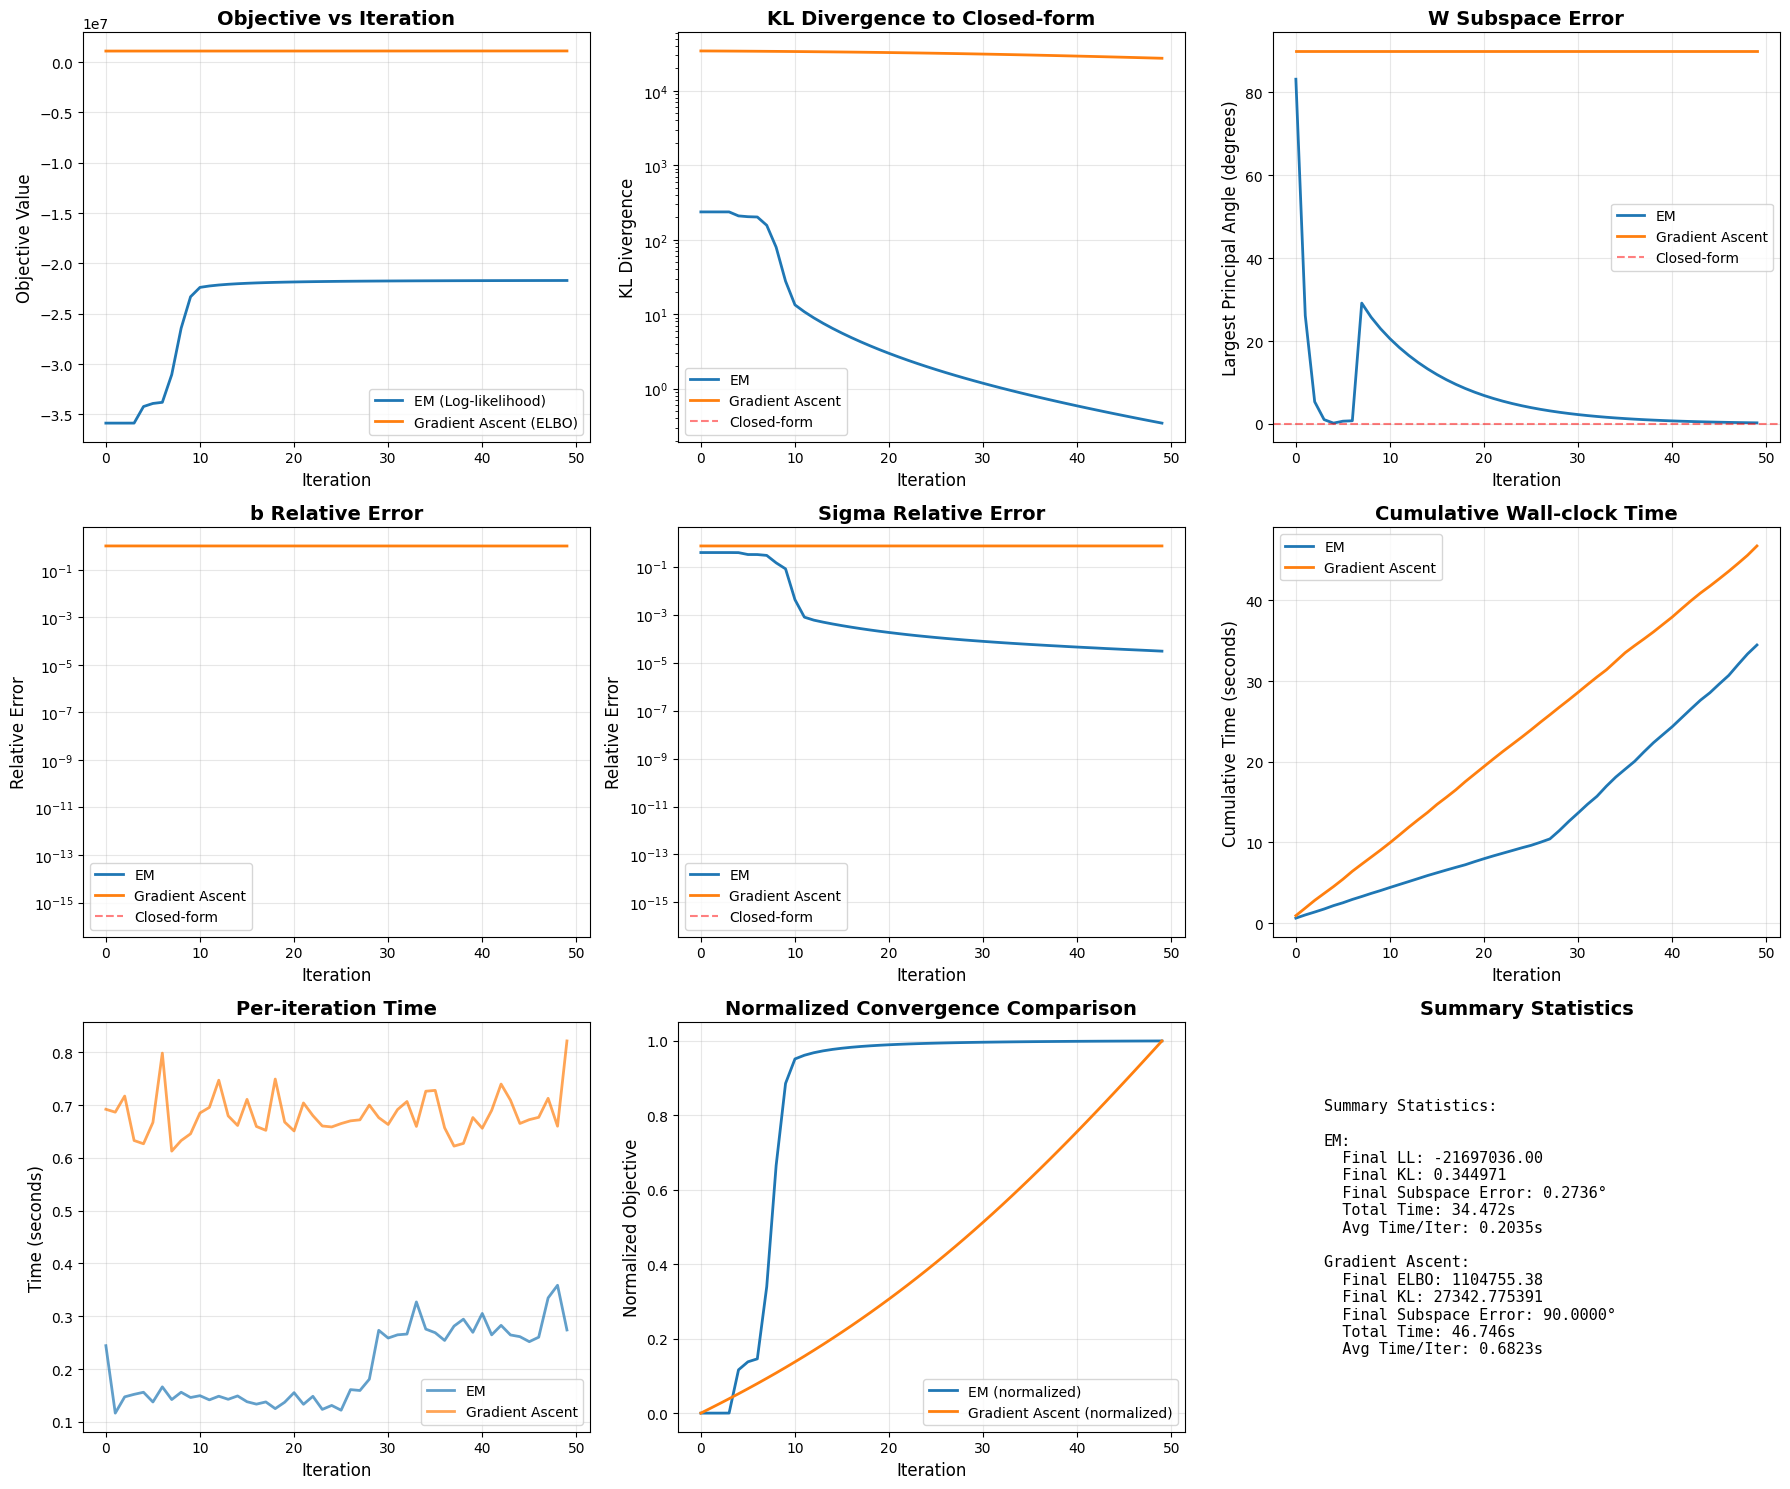


Evaluation metrics complete!


In [ ]:
import time
from scipy.linalg import subspace_angles

def gaussian_kl(mu_p, Sigma_p, mu_q, Sigma_q):
    D = mu_p.shape[0]
    jitter = 1e-6
    Sigma_p_reg = Sigma_p + jitter * torch.eye(D)
    Sigma_q_reg = Sigma_q + jitter * torch.eye(D)
    
    Sigma_q_inv = torch.linalg.inv(Sigma_q_reg)
    trace_term = torch.trace(Sigma_q_inv @ Sigma_p_reg)
    mu_diff = mu_q - mu_p
    quad_term = mu_diff @ Sigma_q_inv @ mu_diff
    
    sign_p, logdet_p = torch.linalg.slogdet(Sigma_p_reg)
    sign_q, logdet_q = torch.linalg.slogdet(Sigma_q_reg)
    log_det_term = logdet_q - logdet_p
    
    kl = 0.5 * (trace_term + quad_term - D + log_det_term)
    return float(kl)

def subspace_error(W_est, W_ref):
    W_est_np = W_est.detach().cpu().numpy()
    W_ref_np = W_ref.detach().cpu().numpy()
    angles_rad = subspace_angles(W_est_np, W_ref_np)
    return float(np.degrees(np.max(angles_rad)))

max_iters = 50
em_ll_hist, elbo_obj_hist = [], []
kl_hist_em, kl_hist_elbo = [], []
subspace_hist_em, subspace_hist_elbo = [], []
b_rel_hist_em, b_rel_hist_elbo = [], []
sigma_rel_hist_em, sigma_rel_hist_elbo = [], []
wall_time_em, wall_time_elbo = [], []
per_iter_time_em, per_iter_time_elbo = [], []

W_star, b_star, sigma_star = closed_form_ppca(X, latent_dim)

b_k = torch.zeros(data_dim)
W_k = torch.eye(data_dim)[:, :latent_dim].contiguous()
sigma_k = torch.tensor(0.1)

em_start = time.time()
for k in range(max_iters):
    iter_start = time.time()
    Ez, EzzT = estep_posterior_moments(X, b_k, W_k, sigma_k)
    b_k, W_k, sigma_k = mstep_update(X, Ez, EzzT)
    per_iter_time_em.append(time.time() - iter_start)
    
    ll = log_likelihood(X, b_k, W_k, sigma_k)
    em_ll_hist.append(float(ll))
    
    Sigma_star = W_star @ W_star.T + sigma_star**2 * torch.eye(data_dim)
    Sigma_k = W_k @ W_k.T + sigma_k**2 * torch.eye(data_dim)
    kl = gaussian_kl(b_star, Sigma_star, b_k, Sigma_k)
    kl_hist_em.append(kl)
    
    subspace_err = subspace_error(W_k, W_star)
    subspace_hist_em.append(subspace_err)
    
    b_rel_err = float(torch.norm(b_star - b_k) / (torch.norm(b_star) + 1e-12))
    b_rel_hist_em.append(b_rel_err)
    
    sigma_rel_err = float(torch.abs(sigma_k - sigma_star) / (torch.abs(sigma_star) + 1e-12))
    sigma_rel_hist_em.append(sigma_rel_err)
    
    wall_time_em.append(time.time() - em_start)
    
    if k % 10 == 0 or k == max_iters - 1:
        print(f"EM {k}: LL={ll:.2f}, KL={kl:.4f}, W_err={subspace_err:.2f}°")
N, D = X.shape
d = latent_dim

W = torch.eye(D)[:, :d].contiguous().clone().requires_grad_(True)
b = torch.zeros(D, requires_grad=True)
log_sigma = torch.log(torch.tensor(0.1)).requires_grad_(True)
A = torch.zeros(d, D, requires_grad=True)
c = torch.zeros(d, requires_grad=True)
log_diag_Sigma_e = torch.zeros(d, requires_grad=True)

params = [W, b, log_sigma, A, c, log_diag_Sigma_e]
optimizer = torch.optim.Adam(params, lr=1e-4)

elbo_start = time.time()

for t in range(max_iters):
    iter_start = time.time()
    optimizer.zero_grad()
    
    sigma = torch.exp(log_sigma)
    Sigma_e = torch.diag(torch.exp(log_diag_Sigma_e))
    elbo_value = compute_elbo(X, W, b, sigma, A, c, Sigma_e)
    loss = -elbo_value
    loss.backward()
    optimizer.step()
    
    per_iter_time_elbo.append(time.time() - iter_start)
    
    with torch.no_grad():
        sigma_detached = torch.exp(log_sigma)
        W_detached = W.detach()
        b_detached = b.detach()
        
        elbo_obj_hist.append(float(elbo_value))
        
        Sigma_star = W_star @ W_star.T + sigma_star**2 * torch.eye(data_dim)
        Sigma_t = W_detached @ W_detached.T + sigma_detached**2 * torch.eye(data_dim)
        kl = gaussian_kl(b_star, Sigma_star, b_detached, Sigma_t)
        kl_hist_elbo.append(kl)
        
        subspace_err = subspace_error(W_detached, W_star)
        subspace_hist_elbo.append(subspace_err)
        
        b_rel_err = float(torch.norm(b_star - b_detached) / (torch.norm(b_star) + 1e-12))
        b_rel_hist_elbo.append(b_rel_err)
        
        sigma_rel_err = float(torch.abs(sigma_detached - sigma_star) / (torch.abs(sigma_star) + 1e-12))
        sigma_rel_hist_elbo.append(sigma_rel_err)
        
        wall_time_elbo.append(time.time() - elbo_start)
        
        if t % 10 == 0 or t == max_iters - 1:
            print(f"ELBO {t}: ELBO={elbo_value:.2f}, KL={kl:.4f}, W_err={subspace_err:.2f}°")

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

axes[0].plot(em_ll_hist, label='EM', linewidth=2)
axes[0].plot(elbo_obj_hist, label='Grad Ascent', linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Objective')
axes[0].set_title('Objective vs Iteration', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(kl_hist_em, label='EM', linewidth=2)
axes[1].plot(kl_hist_elbo, label='Grad Ascent', linewidth=2)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('KL Divergence')
axes[1].set_title('KL to Closed-form', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

axes[2].plot(subspace_hist_em, label='EM', linewidth=2)
axes[2].plot(subspace_hist_elbo, label='Grad Ascent', linewidth=2)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Degrees')
axes[2].set_title('W Subspace Error', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

axes[3].plot(b_rel_hist_em, label='EM', linewidth=2)
axes[3].plot(b_rel_hist_elbo, label='Grad Ascent', linewidth=2)
axes[3].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[3].set_xlabel('Iteration')
axes[3].set_ylabel('Relative Error')
axes[3].set_title('b Error', fontweight='bold')
axes[3].legend()
axes[3].grid(True, alpha=0.3)
axes[3].set_yscale('log')

axes[4].plot(sigma_rel_hist_em, label='EM', linewidth=2)
axes[4].plot(sigma_rel_hist_elbo, label='Grad Ascent', linewidth=2)
axes[4].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[4].set_xlabel('Iteration')
axes[4].set_ylabel('Relative Error')
axes[4].set_title('Sigma Error', fontweight='bold')
axes[4].legend()
axes[4].grid(True, alpha=0.3)
axes[4].set_yscale('log')

axes[5].plot(wall_time_em, label='EM', linewidth=2)
axes[5].plot(wall_time_elbo, label='Grad Ascent', linewidth=2)
axes[5].set_xlabel('Iteration')
axes[5].set_ylabel('Cumulative Time (s)')
axes[5].set_title('Wall-clock Time', fontweight='bold')
axes[5].legend()
axes[5].grid(True, alpha=0.3)

axes[6].plot(per_iter_time_em, label='EM', linewidth=2, alpha=0.7)
axes[6].plot(per_iter_time_elbo, label='Grad Ascent', linewidth=2, alpha=0.7)
axes[6].set_xlabel('Iteration')
axes[6].set_ylabel('Time (s)')
axes[6].set_title('Per-iteration Time', fontweight='bold')
axes[6].legend()
axes[6].grid(True, alpha=0.3)

em_ll_norm = (np.array(em_ll_hist) - np.min(em_ll_hist)) / (np.max(em_ll_hist) - np.min(em_ll_hist) + 1e-12)
elbo_norm = (np.array(elbo_obj_hist) - np.min(elbo_obj_hist)) / (np.max(elbo_obj_hist) - np.min(elbo_obj_hist) + 1e-12)
axes[7].plot(em_ll_norm, label='EM', linewidth=2)
axes[7].plot(elbo_norm, label='Grad Ascent', linewidth=2)
axes[7].set_xlabel('Iteration')
axes[7].set_ylabel('Normalized Objective')
axes[7].set_title('Normalized Convergence', fontweight='bold')
axes[7].legend()
axes[7].grid(True, alpha=0.3)

summary = f"EM: LL={em_ll_hist[-1]:.2f}, KL={kl_hist_em[-1]:.4f}, W_err={subspace_hist_em[-1]:.2f}°\n"
summary += f"    Time={wall_time_em[-1]:.2f}s, Avg/iter={np.mean(per_iter_time_em):.4f}s\n\n"
summary += f"Grad: ELBO={elbo_obj_hist[-1]:.2f}, KL={kl_hist_elbo[-1]:.4f}, W_err={subspace_hist_elbo[-1]:.2f}°\n"
summary += f"      Time={wall_time_elbo[-1]:.2f}s, Avg/iter={np.mean(per_iter_time_elbo):.4f}s"
axes[8].text(0.1, 0.5, summary, fontsize=10, family='monospace', va='center', transform=axes[8].transAxes)
axes[8].axis('off')
axes[8].set_title('Summary', fontweight='bold')

plt.tight_layout()
plt.show()


## Part (e): Effect of noise level
For each method, use the estimated parameters to define a PPCA model, sample from it and visualize the samples.  What happens if we increase the variance of the noise \texttt{eps} to be larger than the estimated $\sigma$? Vary the noise level and describe the quality of the image generation.

Part (e): Effect of Noise Level

Estimated noise levels:
  Closed-form σ: 0.3735
  EM σ: 0.3735
  Gradient Ascent σ: 0.0995

--------------------------------------------------------------------------------
Row 1: Real MNIST samples (for reference)
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Row 2: Noise scale = 0.5× estimated σ_EM = 0.1867
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Row 3: Noise scale = 1.0× estimated σ_EM = 0.3735
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Row 4: Noise scale = 2.0× estimated σ_EM = 0.7469
--------------------------------------------------------------------------------

-------------------------------

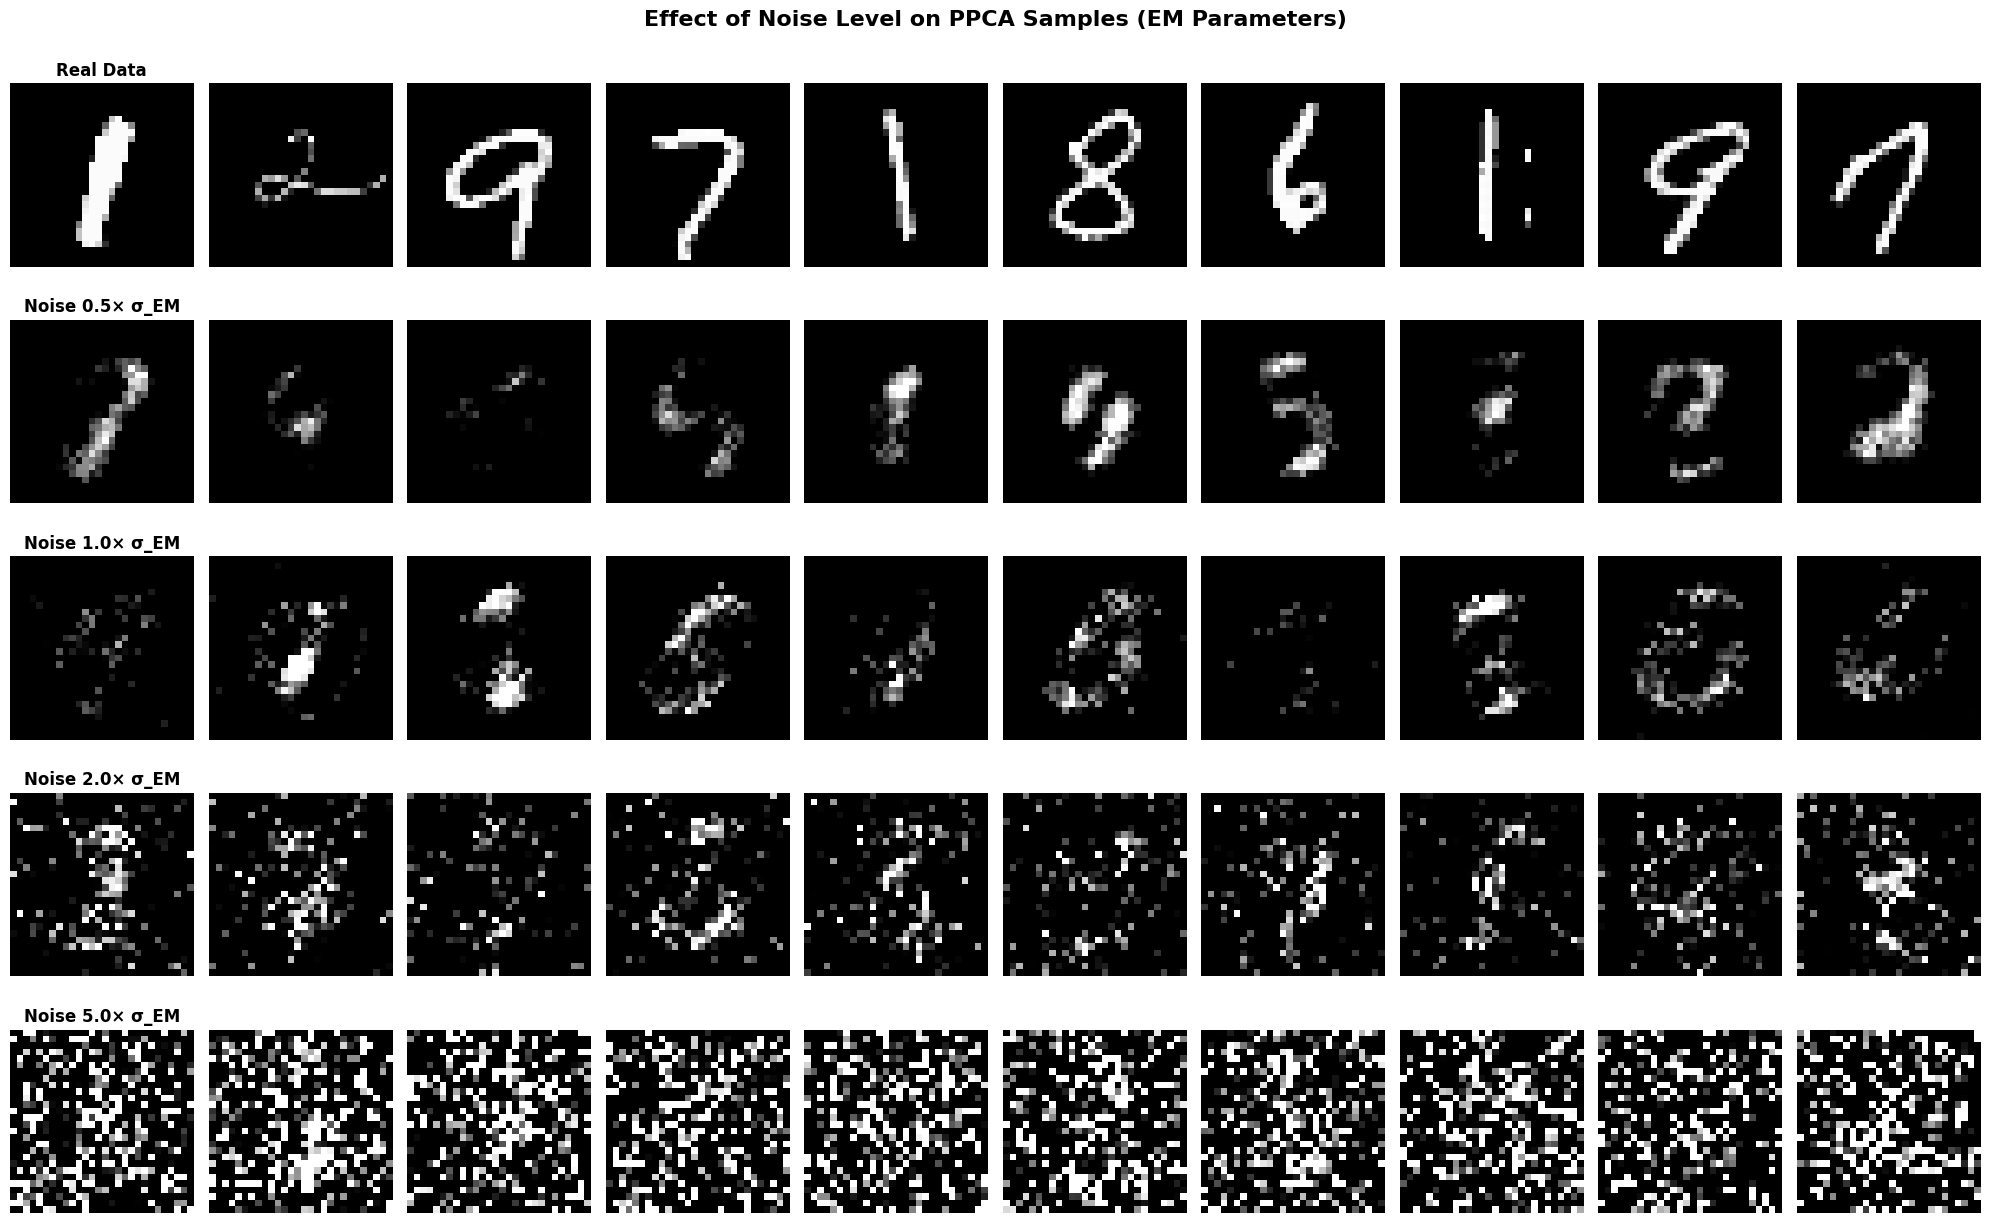


Comparison across different methods

Closed-form: σ = 0.3735
EM: σ = 0.3735
Gradient Ascent: σ = 0.0995


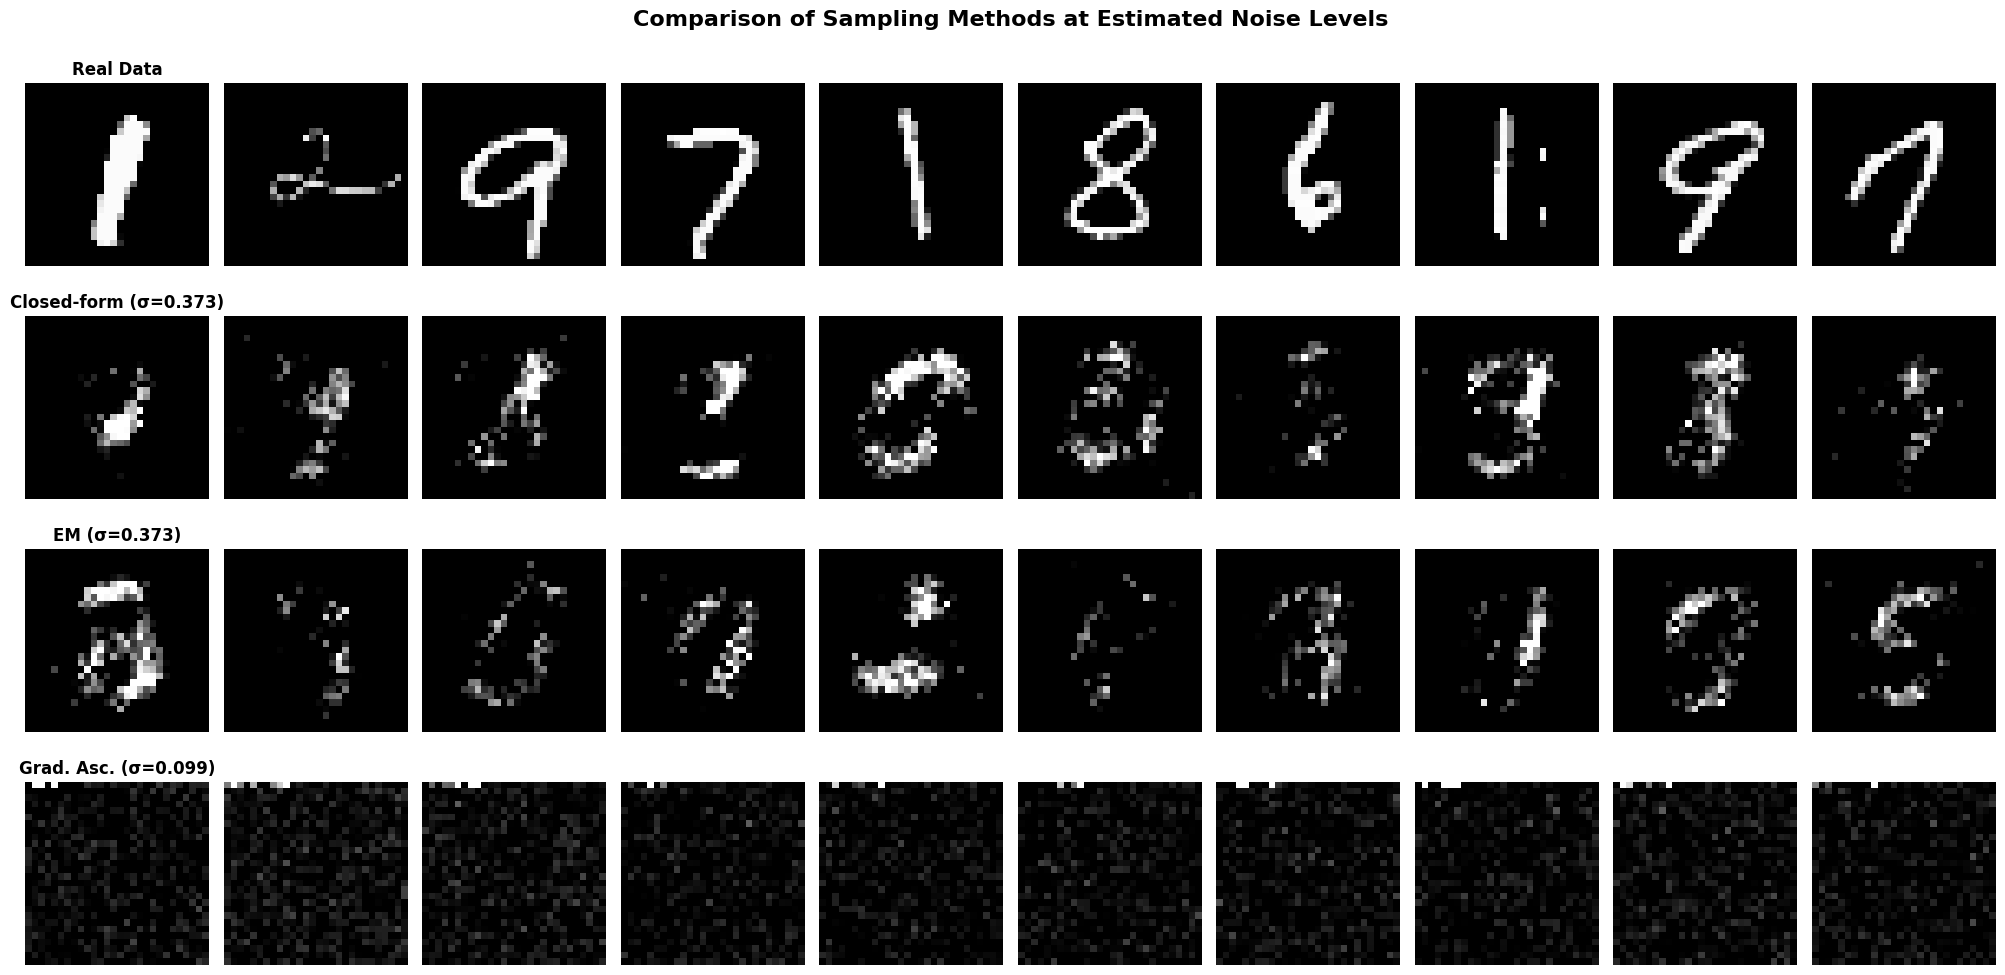


Detailed Noise Level Analysis (EM Parameters)
Noise factor: 0.1× → σ = 0.0373
Noise factor: 0.5× → σ = 0.1867
Noise factor: 1.0× → σ = 0.3735
Noise factor: 2.0× → σ = 0.7469
Noise factor: 5.0× → σ = 1.8673
Noise factor: 10.0× → σ = 3.7347


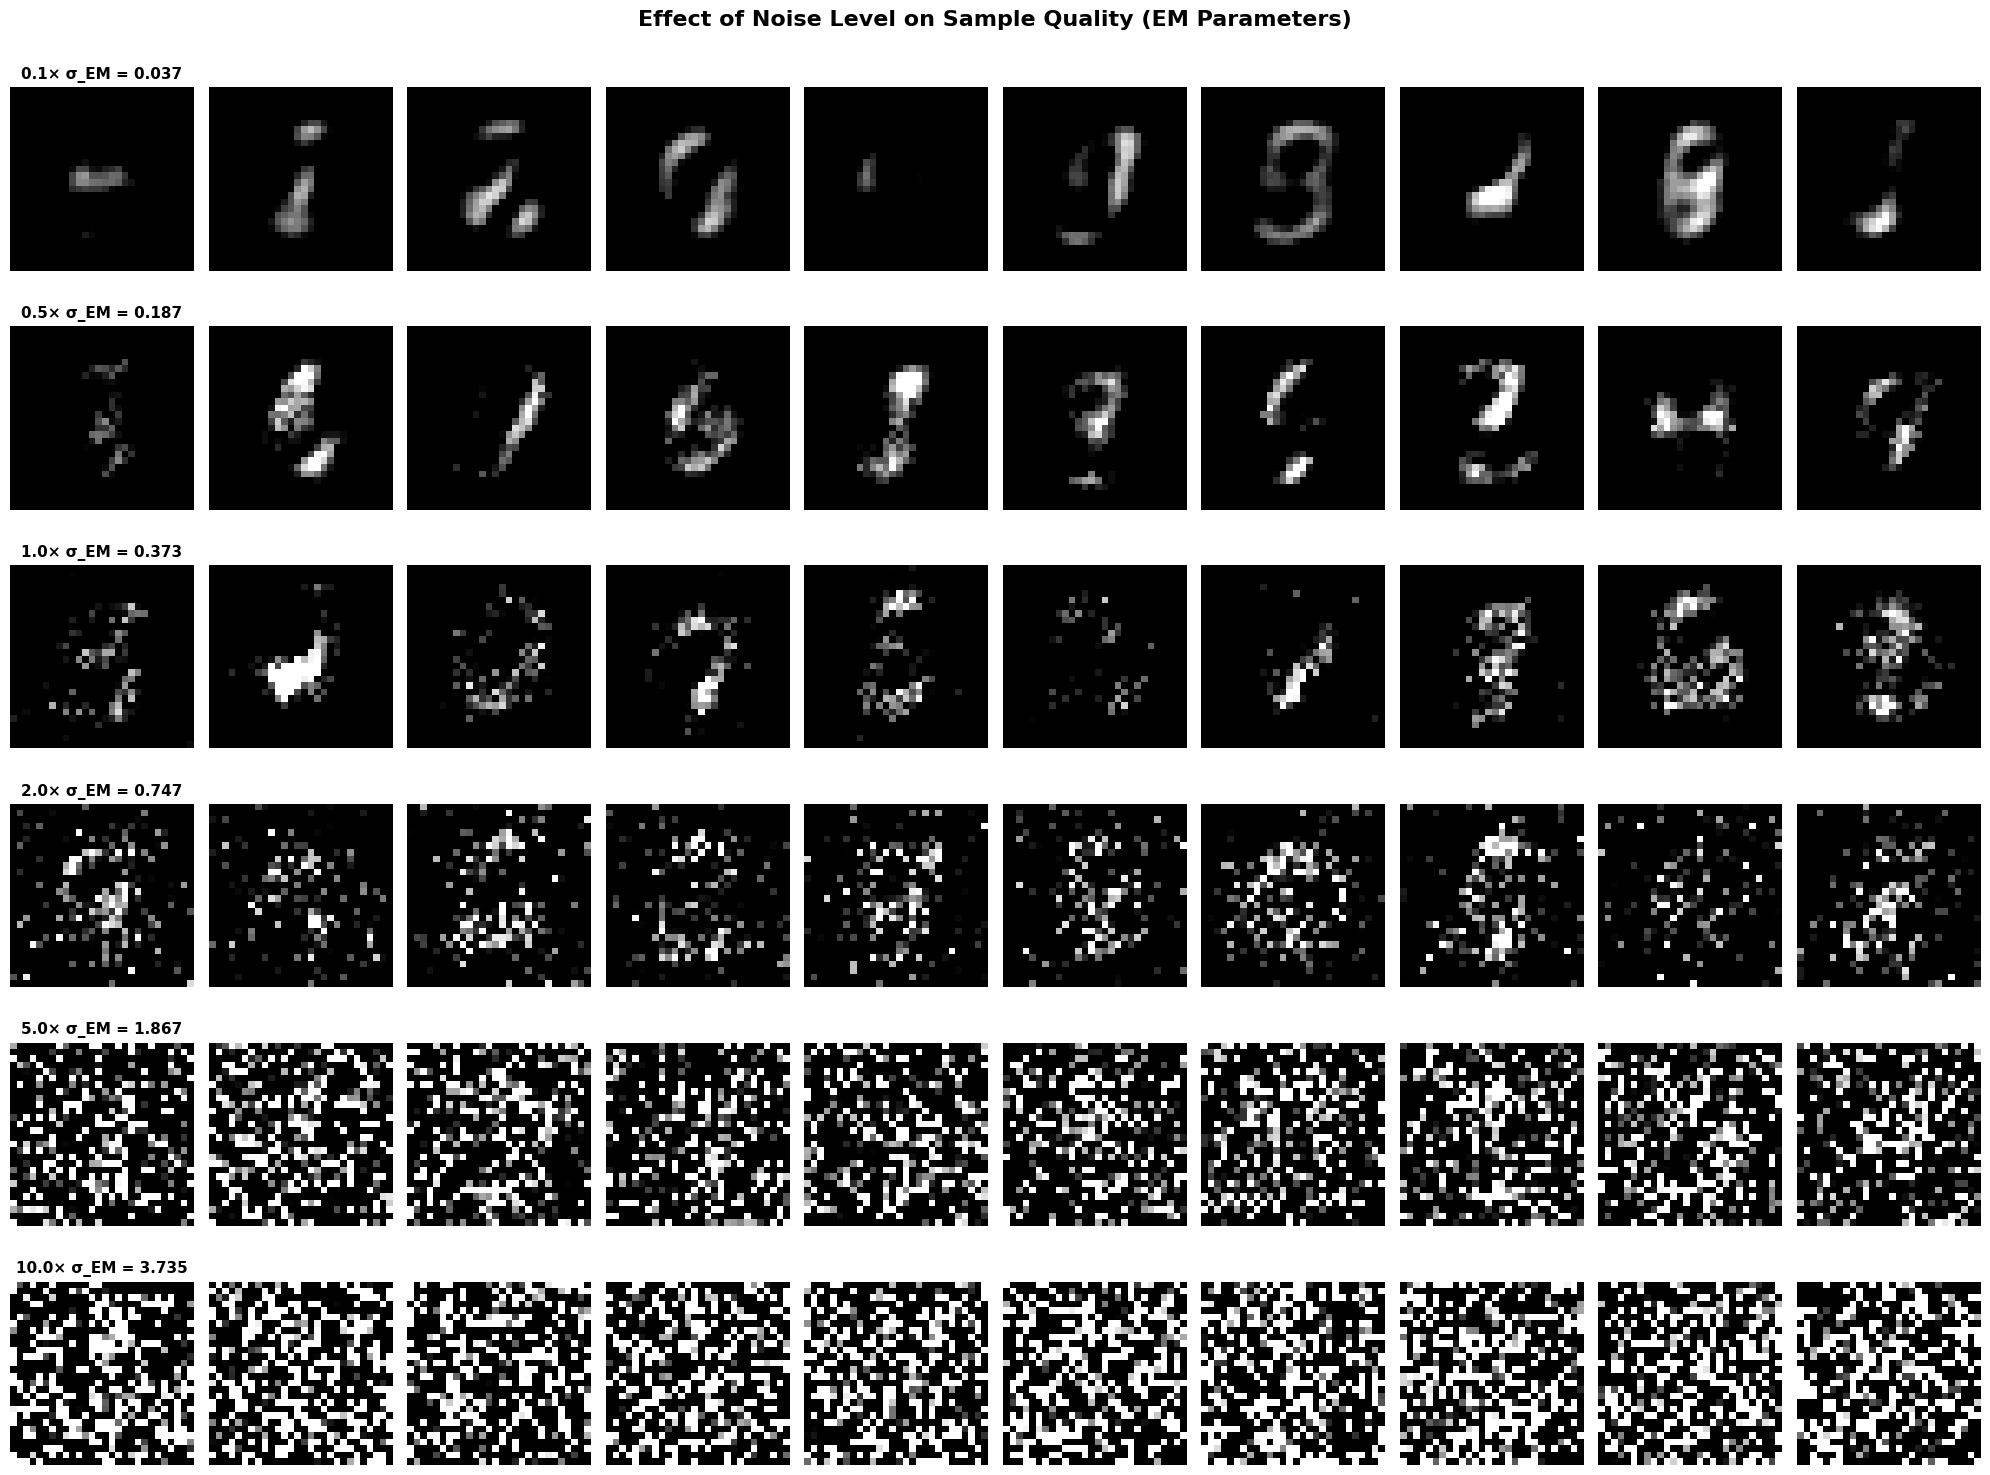

In [ ]:
## Part (e): Effect of noise level

def sample_from_ppca(W, b, sigma, n_samples=10, noise_scale_factor=1.0):
    D, d = W.shape
    z = torch.randn(n_samples, d)
    eps = torch.randn(n_samples, D) * (noise_scale_factor * sigma)
    x_samples = (z @ W.T) + b.unsqueeze(0) + eps
    return x_samples

W_em = W_k.clone()
b_em = b_k.clone()
sigma_em = sigma_k.clone()

W_elbo = W.detach().clone()
b_elbo = b.detach().clone()
sigma_elbo = torch.exp(log_sigma).detach().clone()

print(f"Noise levels: Closed-form={sigma_star:.4f}, EM={sigma_em:.4f}, GradAsc={sigma_elbo:.4f}")

noise_factors = [0.5, 1.0, 2.0, 5.0]
n_samples_per_setting = 10

fig, axes = plt.subplots(len(noise_factors) + 1, n_samples_per_setting, 
                         figsize=(20, 2.5 * (len(noise_factors) + 1)))

real_sample_idxs = np.random.choice(X.shape[0], n_samples_per_setting, replace=False)
for j in range(n_samples_per_setting):
    axes[0, j].imshow(X[real_sample_idxs[j]].reshape(28, 28).numpy(), cmap='gray', vmin=0, vmax=1)
    axes[0, j].axis('off')
    if j == 0:
        axes[0, j].set_title('Real Data', fontweight='bold')

for i, noise_factor in enumerate(noise_factors):
    row_idx = i + 1
    samples_em = sample_from_ppca(W_em, b_em, sigma_em, n_samples=n_samples_per_setting, noise_scale_factor=noise_factor)
    
    for j in range(n_samples_per_setting):
        img = np.clip(samples_em[j].reshape(28, 28).numpy(), 0, 1)
        axes[row_idx, j].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[row_idx, j].axis('off')
        if j == 0:
            axes[row_idx, j].set_title(f'{noise_factor}× σ', fontweight='bold')

plt.suptitle('Effect of Noise Level (EM)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Compare all three methods at their estimated noise levels
fig2, axes2 = plt.subplots(4, n_samples_per_setting, figsize=(20, 10))

# Row 0: Real samples
for j in range(n_samples_per_setting):
    axes2[0, j].imshow(X[real_sample_idxs[j]].reshape(28, 28).numpy(), cmap='gray', vmin=0, vmax=1)
    axes2[0, j].axis('off')
    if j == 0:
        axes2[0, j].set_title('Real Data', fontsize=12, fontweight='bold')

# Row 1: Closed-form samples
samples_cf = sample_from_ppca(W_star, b_star, sigma_star, n_samples=n_samples_per_setting)
print(f"\nClosed-form: σ = {sigma_star:.4f}")
for j in range(n_samples_per_setting):
    img = np.clip(samples_cf[j].reshape(28, 28).numpy(), 0, 1)
    axes2[1, j].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes2[1, j].axis('off')
    if j == 0:
        axes2[1, j].set_title(f'Closed-form (σ={sigma_star:.3f})', 
                             fontsize=12, fontweight='bold')

# Row 2: EM samples
samples_em_est = sample_from_ppca(W_em, b_em, sigma_em, n_samples=n_samples_per_setting)
print(f"EM: σ = {sigma_em:.4f}")
for j in range(n_samples_per_setting):
    img = np.clip(samples_em_est[j].reshape(28, 28).numpy(), 0, 1)
    axes2[2, j].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes2[2, j].axis('off')
    if j == 0:
        axes2[2, j].set_title(f'EM (σ={sigma_em:.3f})', fontsize=12, fontweight='bold')

# Row 3: Gradient Ascent samples
samples_elbo = sample_from_ppca(W_elbo, b_elbo, sigma_elbo, n_samples=n_samples_per_setting)
print(f"Gradient Ascent: σ = {sigma_elbo:.4f}")
for j in range(n_samples_per_setting):
    img = np.clip(samples_elbo[j].reshape(28, 28).numpy(), 0, 1)
    axes2[3, j].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes2[3, j].axis('off')
    if j == 0:
        axes2[3, j].set_title(f'Grad. Asc. (σ={sigma_elbo:.3f})', 
                             fontsize=12, fontweight='bold')

plt.suptitle('Comparison of Sampling Methods at Estimated Noise Levels', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Detailed noise level exploration for EM
print("\n" + "=" * 80)
print("Detailed Noise Level Analysis (EM Parameters)")
print("=" * 80)

noise_levels = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
fig3, axes3 = plt.subplots(len(noise_levels), n_samples_per_setting, 
                           figsize=(20, 2.5 * len(noise_levels)))

for i, noise_factor in enumerate(noise_levels):
    actual_sigma = noise_factor * sigma_em
    samples = sample_from_ppca(W_em, b_em, sigma_em, 
                              n_samples=n_samples_per_setting, 
                              noise_scale_factor=noise_factor)
    
    print(f"Noise factor: {noise_factor}× → σ = {actual_sigma:.4f}")
    
    for j in range(n_samples_per_setting):
        img = np.clip(samples[j].reshape(28, 28).numpy(), 0, 1)
        axes3[i, j].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes3[i, j].axis('off')
        
        if j == 0:
            axes3[i, j].set_title(f'{noise_factor}× σ_EM = {actual_sigma:.3f}', 
                                 fontsize=11, fontweight='bold')

plt.suptitle('Effect of Noise Level on Sample Quality (EM Parameters)', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()


Lower noise → cleaner samples; Higher noise → blurrier samples; Extreme noise → unrecognizable



## Part (f): Effect of latent dimension $d$
What role does the latent space dimension $d$ play? Describe the quality of generation with respect to $d$.

Part (f): Effect of Latent Dimension d

Training PPCA with latent dimension d = 2
  Log-likelihood: -31859982.00
  Variance explained: 0.1659
  Reconstruction error (MSE): 0.231100
  Estimated σ: 0.4737

Training PPCA with latent dimension d = 5
  Log-likelihood: -27163730.00
  Variance explained: 0.3280
  Reconstruction error (MSE): 0.176390
  Estimated σ: 0.4252

Training PPCA with latent dimension d = 10
  Log-likelihood: -21676360.00
  Variance explained: 0.4815
  Reconstruction error (MSE): 0.133997
  Estimated σ: 0.3735

Training PPCA with latent dimension d = 20
  Log-likelihood: -14620137.00
  Variance explained: 0.6343
  Reconstruction error (MSE): 0.090187
  Estimated σ: 0.3137

Training PPCA with latent dimension d = 50
  Log-likelihood: -2131323.25
  Variance explained: 0.8127
  Reconstruction error (MSE): 0.047444
  Estimated σ: 0.2245

Training PPCA with latent dimension d = 100
  Log-likelihood: 8251459.50
  Variance explained: 0.9021
  Reconstruction error (MSE): 0.0229

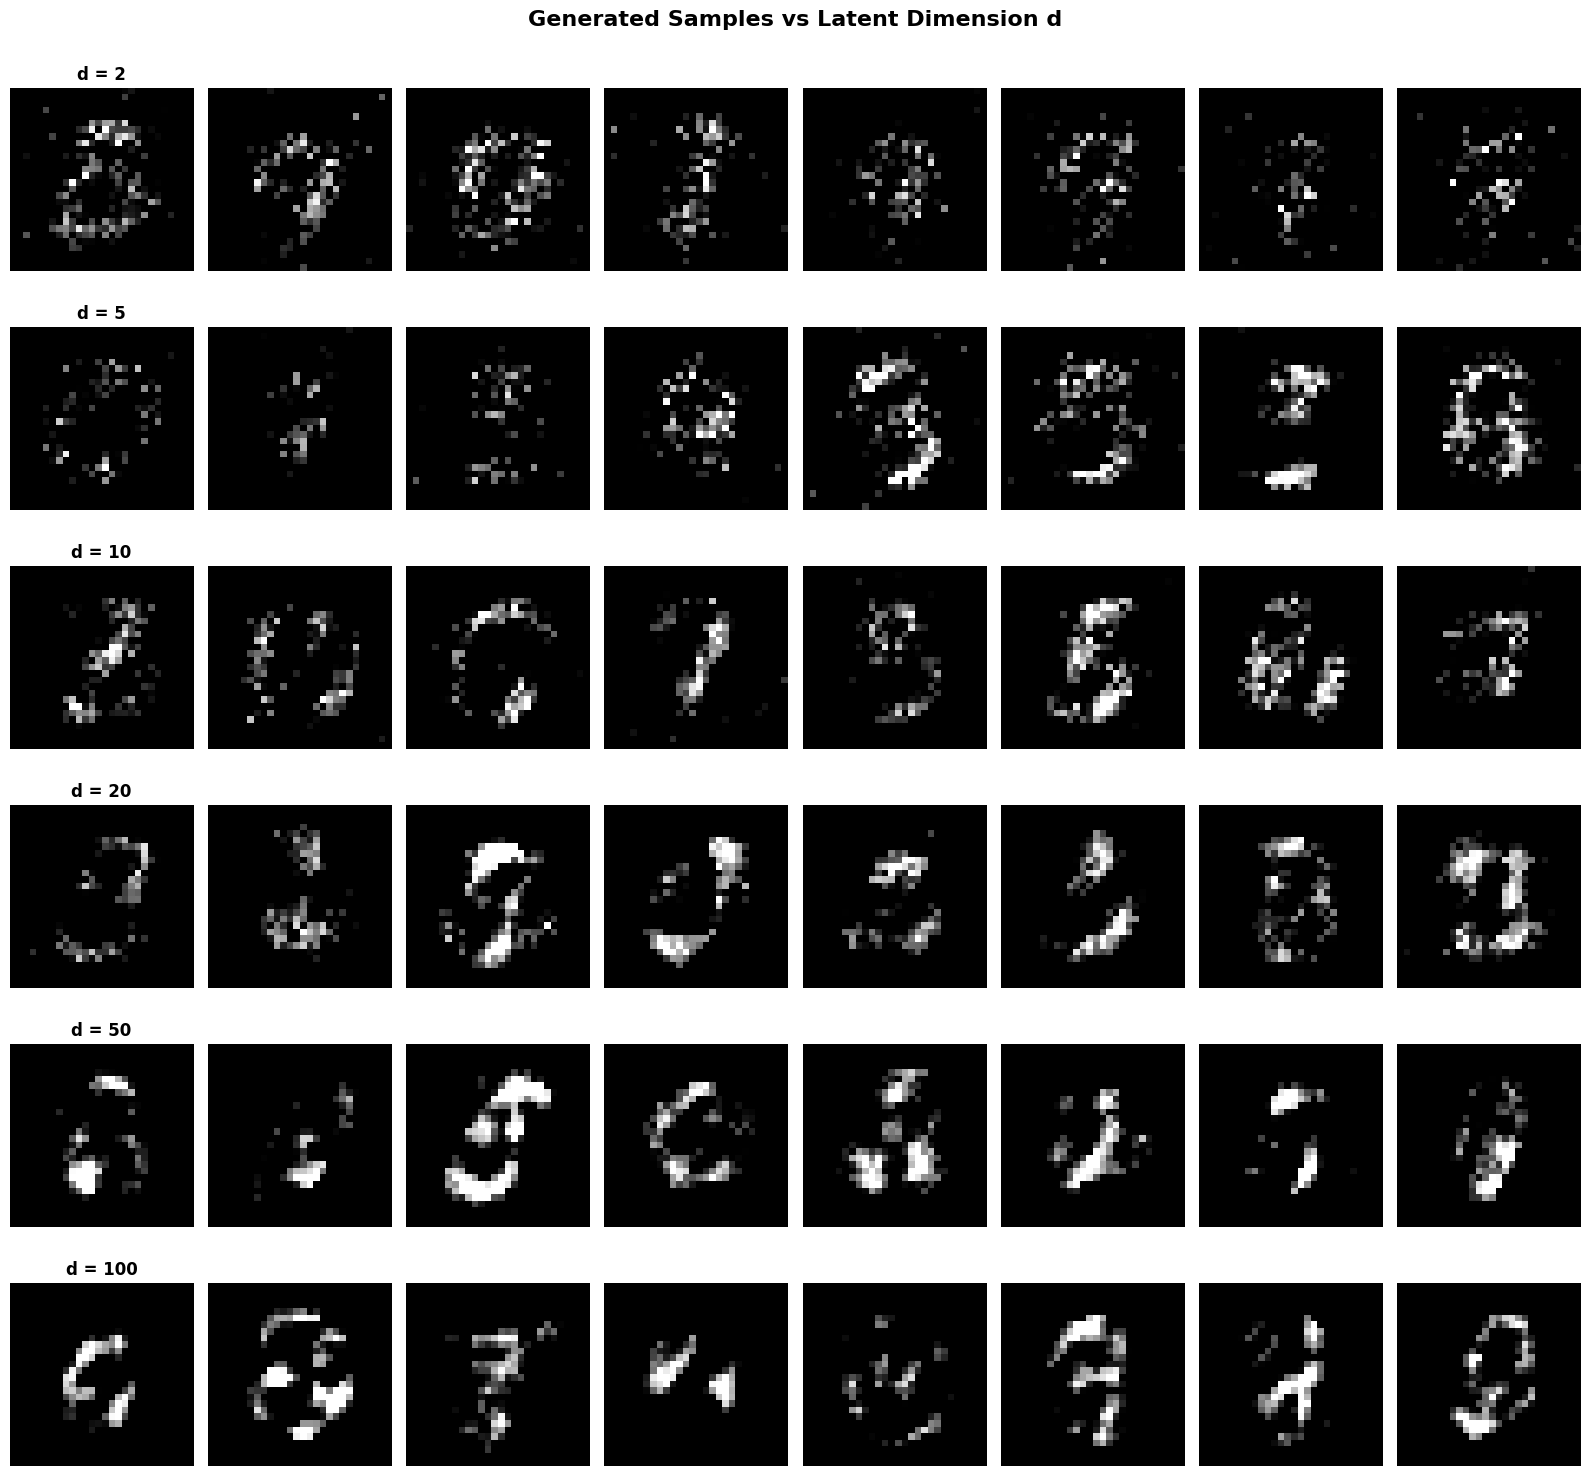

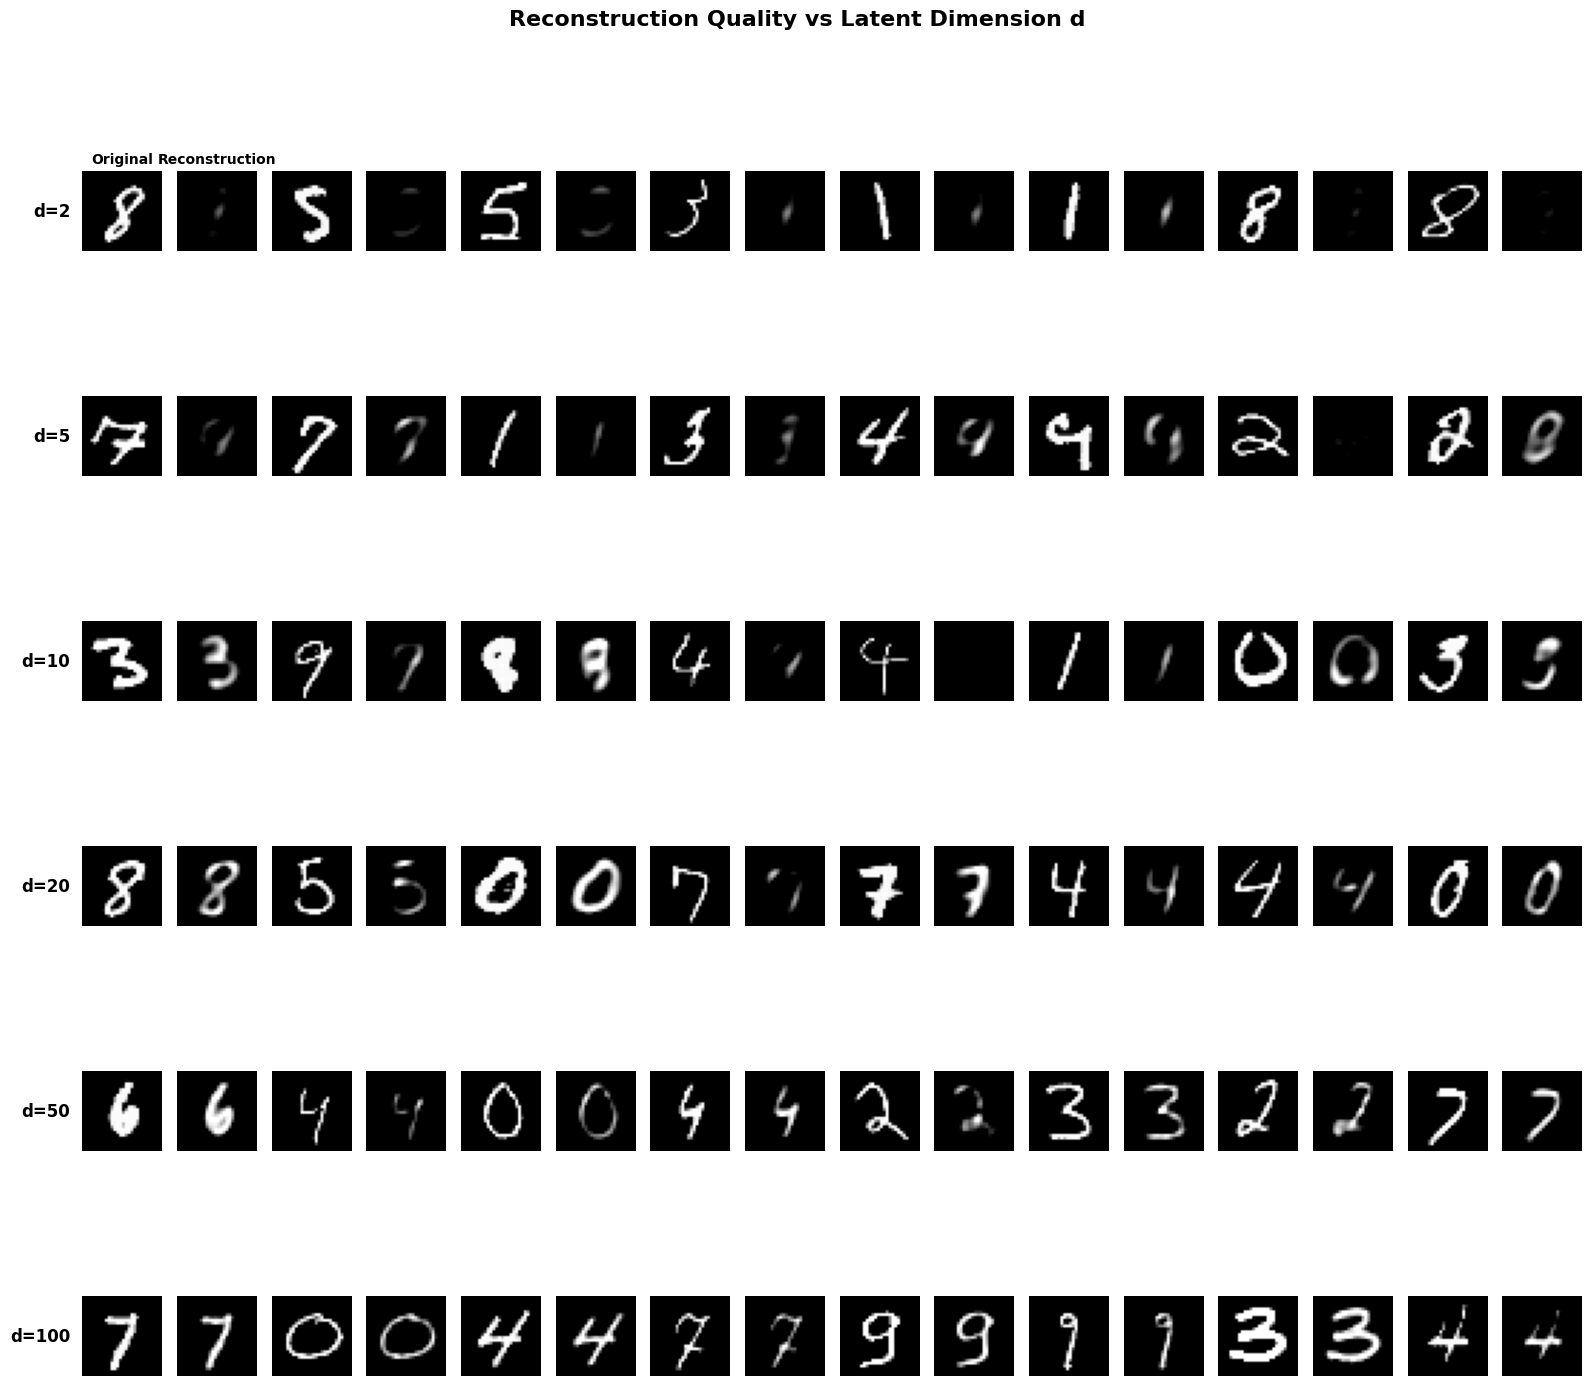

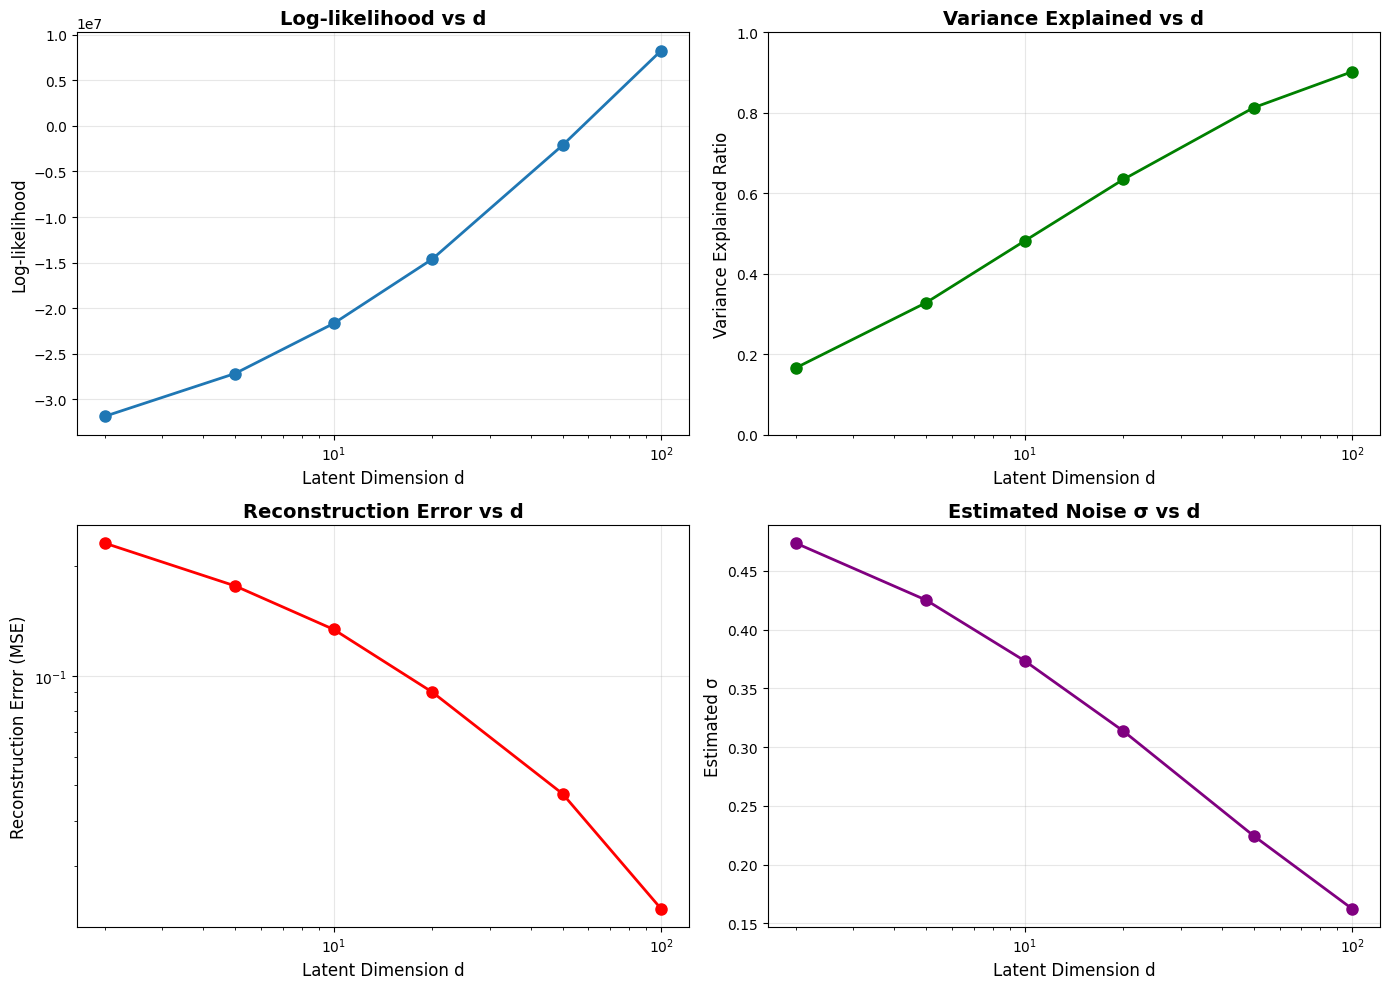


Visualizing Principal Components (d=10)


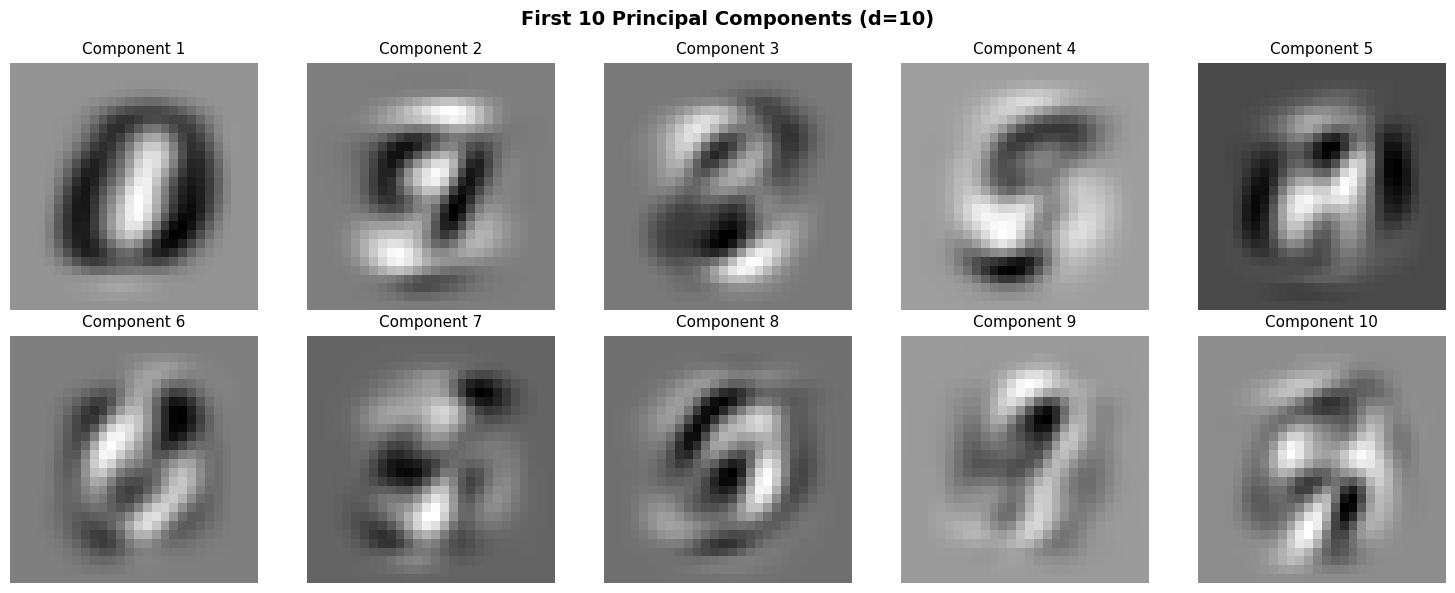


Summary Table
    d      Log-lik   Var Expl    Recon Err        σ
--------------------------------------------------------------------------------
    2 -31859982.00     0.1659     0.231100   0.4737
    5 -27163730.00     0.3280     0.176390   0.4252
   10 -21676360.00     0.4815     0.133997   0.3735
   20 -14620137.00     0.6343     0.090187   0.3137
   50  -2131323.25     0.8127     0.047444   0.2245
  100   8251459.50     0.9021     0.022929   0.1622


In [55]:
## Part (f): Effect of latent dimension d - Implementation

print("=" * 80)
print("Part (f): Effect of Latent Dimension d")
print("=" * 80)

# Test different latent dimensions
latent_dims = [2, 5, 10, 20, 50, 100]
n_samples_viz = 8

# Store results for each dimension
results_by_dim = {}

for d in latent_dims:
    print(f"\n{'=' * 80}")
    print(f"Training PPCA with latent dimension d = {d}")
    print(f"{'=' * 80}")
    
    # Closed-form PPCA
    W_d, b_d, sigma_d = closed_form_ppca(X, d)
    
    # Compute log-likelihood
    ll_d = log_likelihood(X, b_d, W_d, sigma_d)
    
    # Compute variance explained
    # Variance explained = variance captured by W / total variance
    total_var = torch.var(X, dim=0).sum()
    model_var = torch.trace(W_d @ W_d.T)
    noise_var = sigma_d**2 * data_dim
    variance_explained_ratio = float(model_var / (model_var + noise_var))
    
    # Generate samples
    samples_d = sample_from_ppca(W_d, b_d, sigma_d, n_samples=n_samples_viz)
    
    # Compute reconstruction error on test samples
    # For PPCA: E[x|z] = W*E[z|x] + b, where E[z|x] = (W^T W + sigma^2 I)^{-1} W^T (x - b)
    test_indices = np.random.choice(X.shape[0], 100, replace=False)
    X_test = X[test_indices]
    
    # Compute posterior mean of z
    WtW = W_d.T @ W_d
    sigma_sq = sigma_d**2
    posterior_cov_inv = WtW + sigma_sq * torch.eye(d)
    X_centered = X_test - b_d.unsqueeze(0)
    z_posterior = X_centered @ W_d @ torch.linalg.inv(posterior_cov_inv)
    
    # Reconstruct: x_recon = W * z_posterior + b
    X_recon = z_posterior @ W_d.T + b_d.unsqueeze(0)
    recon_error = torch.mean((X_test - X_recon)**2)
    
    # Store results
    results_by_dim[d] = {
        'W': W_d,
        'b': b_d,
        'sigma': sigma_d,
        'll': float(ll_d),
        'variance_explained': variance_explained_ratio,
        'samples': samples_d,
        'recon_error': float(recon_error),
        'X_test': X_test[:n_samples_viz],
        'X_recon': X_recon[:n_samples_viz]
    }
    
    print(f"  Log-likelihood: {ll_d:.2f}")
    print(f"  Variance explained: {variance_explained_ratio:.4f}")
    print(f"  Reconstruction error (MSE): {recon_error:.6f}")
    print(f"  Estimated σ: {sigma_d:.4f}")

# Visualization 1: Generated samples for each dimension
print("\n" + "=" * 80)
print("Generating Comparison Plots")
print("=" * 80)

fig1, axes1 = plt.subplots(len(latent_dims), n_samples_viz, 
                           figsize=(16, 2.5 * len(latent_dims)))

for i, d in enumerate(latent_dims):
    samples = results_by_dim[d]['samples']
    
    for j in range(n_samples_viz):
        img = np.clip(samples[j].reshape(28, 28).numpy(), 0, 1)
        axes1[i, j].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes1[i, j].axis('off')
        
        if j == 0:
            axes1[i, j].set_title(f'd = {d}', fontsize=12, fontweight='bold')

plt.suptitle('Generated Samples vs Latent Dimension d', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

# Visualization 2: Reconstruction quality
fig2, axes2 = plt.subplots(len(latent_dims), n_samples_viz * 2, 
                           figsize=(16, 2.5 * len(latent_dims)))

for i, d in enumerate(latent_dims):
    X_test = results_by_dim[d]['X_test']
    X_recon = results_by_dim[d]['X_recon']
    
    for j in range(n_samples_viz):
        # Original
        img_orig = X_test[j].reshape(28, 28).numpy()
        axes2[i, 2*j].imshow(img_orig, cmap='gray', vmin=0, vmax=1)
        axes2[i, 2*j].axis('off')
        if i == 0 and j == 0:
            axes2[i, 2*j].set_title('Original', fontsize=10, fontweight='bold')
        
        # Reconstruction
        img_recon = np.clip(X_recon[j].reshape(28, 28).numpy(), 0, 1)
        axes2[i, 2*j + 1].imshow(img_recon, cmap='gray', vmin=0, vmax=1)
        axes2[i, 2*j + 1].axis('off')
        if i == 0 and j == 0:
            axes2[i, 2*j + 1].set_title('Reconstruction', fontsize=10, fontweight='bold')
        
        if j == 0:
            axes2[i, 0].text(-0.15, 0.5, f'd={d}', transform=axes2[i, 0].transAxes,
                           fontsize=12, fontweight='bold', va='center', ha='right')

plt.suptitle('Reconstruction Quality vs Latent Dimension d', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

# Visualization 3: Metrics vs latent dimension
fig3, axes3 = plt.subplots(2, 2, figsize=(14, 10))

# Log-likelihood
lls = [results_by_dim[d]['ll'] for d in latent_dims]
axes3[0, 0].plot(latent_dims, lls, 'o-', linewidth=2, markersize=8)
axes3[0, 0].set_xlabel('Latent Dimension d', fontsize=12)
axes3[0, 0].set_ylabel('Log-likelihood', fontsize=12)
axes3[0, 0].set_title('Log-likelihood vs d', fontsize=14, fontweight='bold')
axes3[0, 0].grid(True, alpha=0.3)
axes3[0, 0].set_xscale('log')

# Variance explained
var_expl = [results_by_dim[d]['variance_explained'] for d in latent_dims]
axes3[0, 1].plot(latent_dims, var_expl, 'o-', linewidth=2, markersize=8, color='green')
axes3[0, 1].set_xlabel('Latent Dimension d', fontsize=12)
axes3[0, 1].set_ylabel('Variance Explained Ratio', fontsize=12)
axes3[0, 1].set_title('Variance Explained vs d', fontsize=14, fontweight='bold')
axes3[0, 1].grid(True, alpha=0.3)
axes3[0, 1].set_xscale('log')
axes3[0, 1].set_ylim([0, 1])

# Reconstruction error
recon_errs = [results_by_dim[d]['recon_error'] for d in latent_dims]
axes3[1, 0].plot(latent_dims, recon_errs, 'o-', linewidth=2, markersize=8, color='red')
axes3[1, 0].set_xlabel('Latent Dimension d', fontsize=12)
axes3[1, 0].set_ylabel('Reconstruction Error (MSE)', fontsize=12)
axes3[1, 0].set_title('Reconstruction Error vs d', fontsize=14, fontweight='bold')
axes3[1, 0].grid(True, alpha=0.3)
axes3[1, 0].set_xscale('log')
axes3[1, 0].set_yscale('log')

# Estimated sigma
sigmas = [float(results_by_dim[d]['sigma']) for d in latent_dims]
axes3[1, 1].plot(latent_dims, sigmas, 'o-', linewidth=2, markersize=8, color='purple')
axes3[1, 1].set_xlabel('Latent Dimension d', fontsize=12)
axes3[1, 1].set_ylabel('Estimated σ', fontsize=12)
axes3[1, 1].set_title('Estimated Noise σ vs d', fontsize=14, fontweight='bold')
axes3[1, 1].grid(True, alpha=0.3)
axes3[1, 1].set_xscale('log')

plt.tight_layout()
plt.show()

# Visualization 4: First few principal components for d=10
print("\n" + "=" * 80)
print("Visualizing Principal Components (d=10)")
print("=" * 80)

d_viz = 10
W_viz = results_by_dim[d_viz]['W']

fig4, axes4 = plt.subplots(2, 5, figsize=(15, 6))
axes4 = axes4.ravel()

for i in range(min(d_viz, 10)):
    component = W_viz[:, i].reshape(28, 28).numpy()
    # Normalize for better visualization
    component = (component - component.min()) / (component.max() - component.min() + 1e-8)
    
    axes4[i].imshow(component, cmap='gray')
    axes4[i].set_title(f'Component {i+1}', fontsize=11)
    axes4[i].axis('off')

plt.suptitle(f'First {min(d_viz, 10)} Principal Components (d={d_viz})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "=" * 80)
print("Summary Table")
print("=" * 80)
print(f"{'d':>5} {'Log-lik':>12} {'Var Expl':>10} {'Recon Err':>12} {'σ':>8}")
print("-" * 80)
for d in latent_dims:
    ll = results_by_dim[d]['ll']
    var_exp = results_by_dim[d]['variance_explained']
    recon = results_by_dim[d]['recon_error']
    sig = results_by_dim[d]['sigma']
    print(f"{d:>5} {ll:>12.2f} {var_exp:>10.4f} {recon:>12.6f} {sig:>8.4f}")


## Part (g): Effect of sample size $N$
Keep $d$ fixed. Compare the performance when using many samples ($N \gg d$), a moderate number of samples ($N = d$), and a small number of samples $N < d$. Discuss trends in the convergence of objective, errors, and the sample quality using the estimated PPCA model.

Part (g): Effect of Sample Size N

Fixed latent dimension: d = 10

Computing REFERENCE solution (full dataset, N=60000)
Reference log-likelihood: -21676364.00
Reference σ: 0.3735

Training PPCA with N = 100 samples (d = 10)
  Final log-likelihood: -29619.02
  Final b error: 0.068864
  Final W subspace error: 68.7875°
  Final σ error: 0.082493
  Estimated σ: 0.3426
  Reconstruction error: 0.115942

Training PPCA with N = 200 samples (d = 10)
  Final log-likelihood: -64923.79
  Final b error: 0.031353
  Final W subspace error: 43.6937°
  Final σ error: 0.047154
  Estimated σ: 0.3558
  Reconstruction error: 0.126738

Training PPCA with N = 500 samples (d = 10)
  Final log-likelihood: -173558.62
  Final b error: 0.034918
  Final W subspace error: 22.8502°
  Final σ error: 0.019015
  Estimated σ: 0.3664
  Reconstruction error: 0.133665

Training PPCA with N = 1000 samples (d = 10)
  Final log-likelihood: -356707.22
  Final b error: 0.015633
  Final W subspace error: 18.9025°
  Final σ error

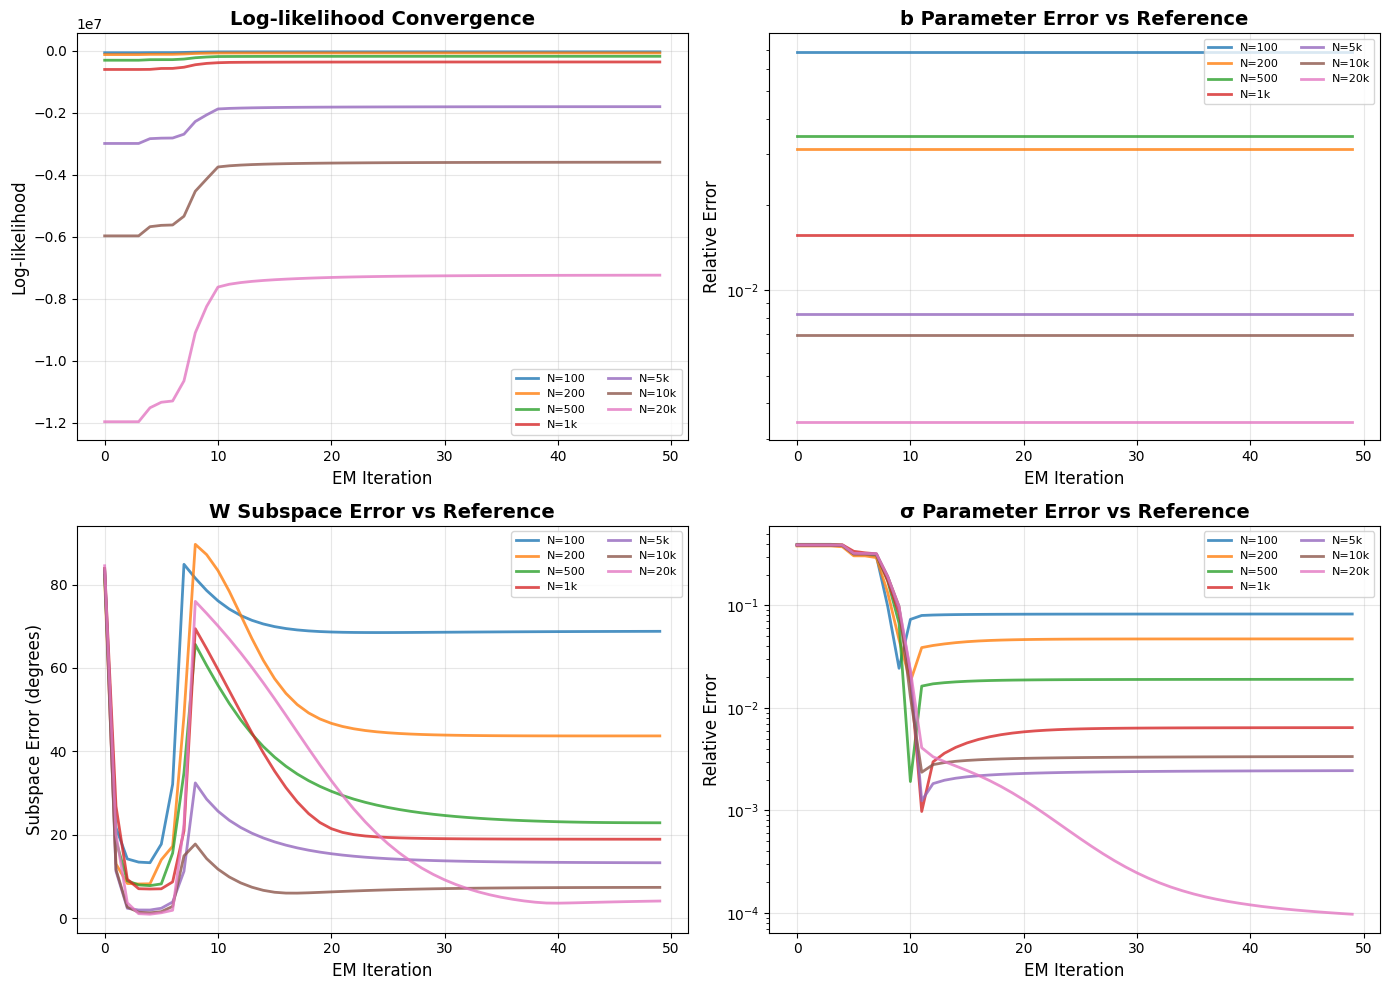

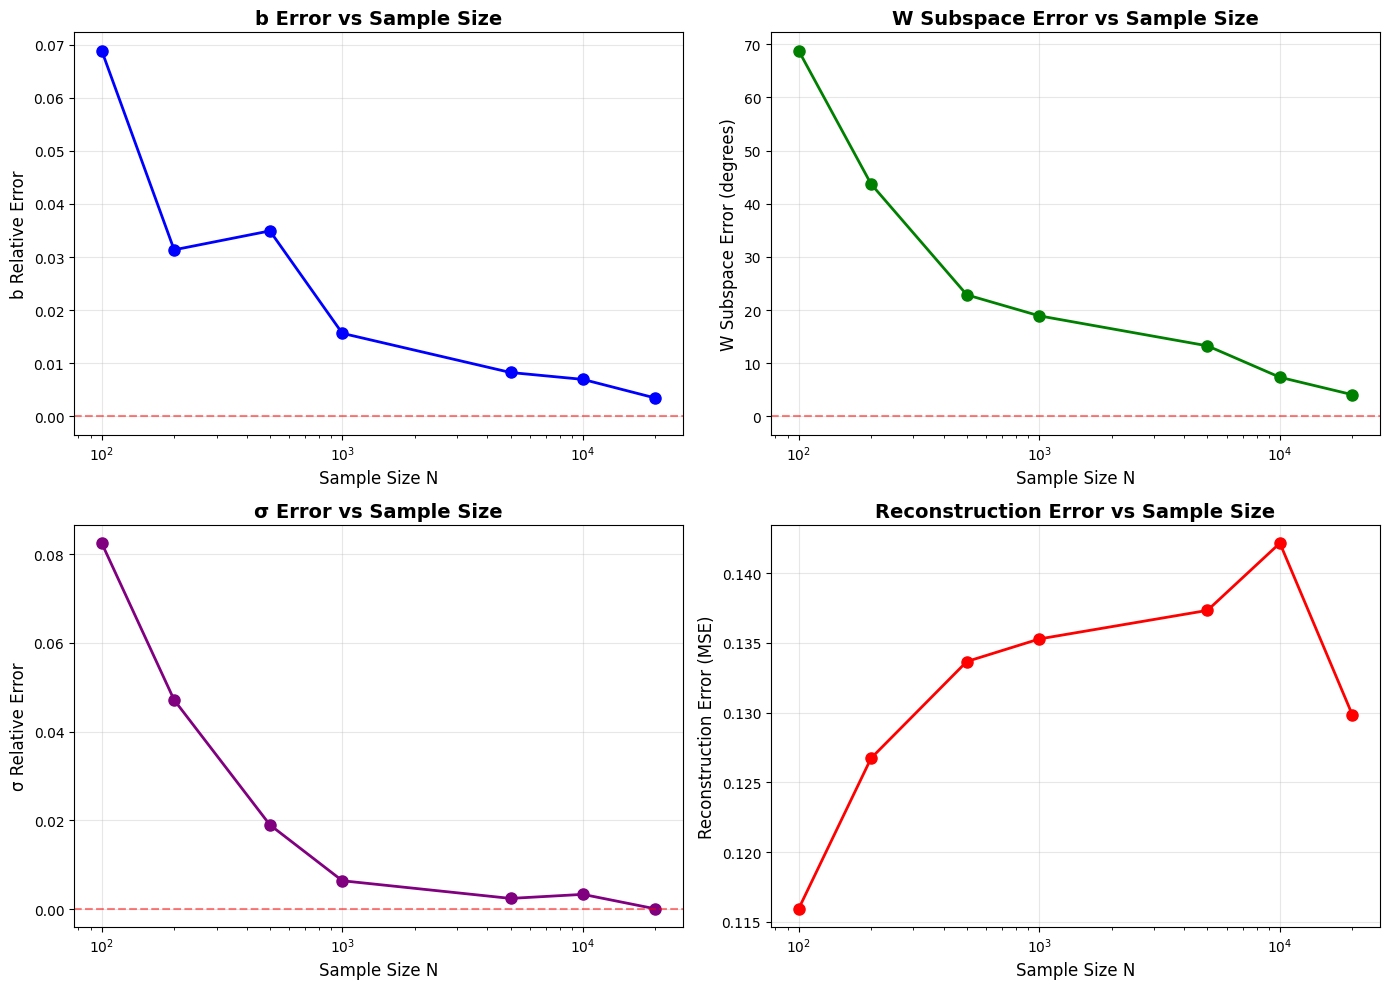

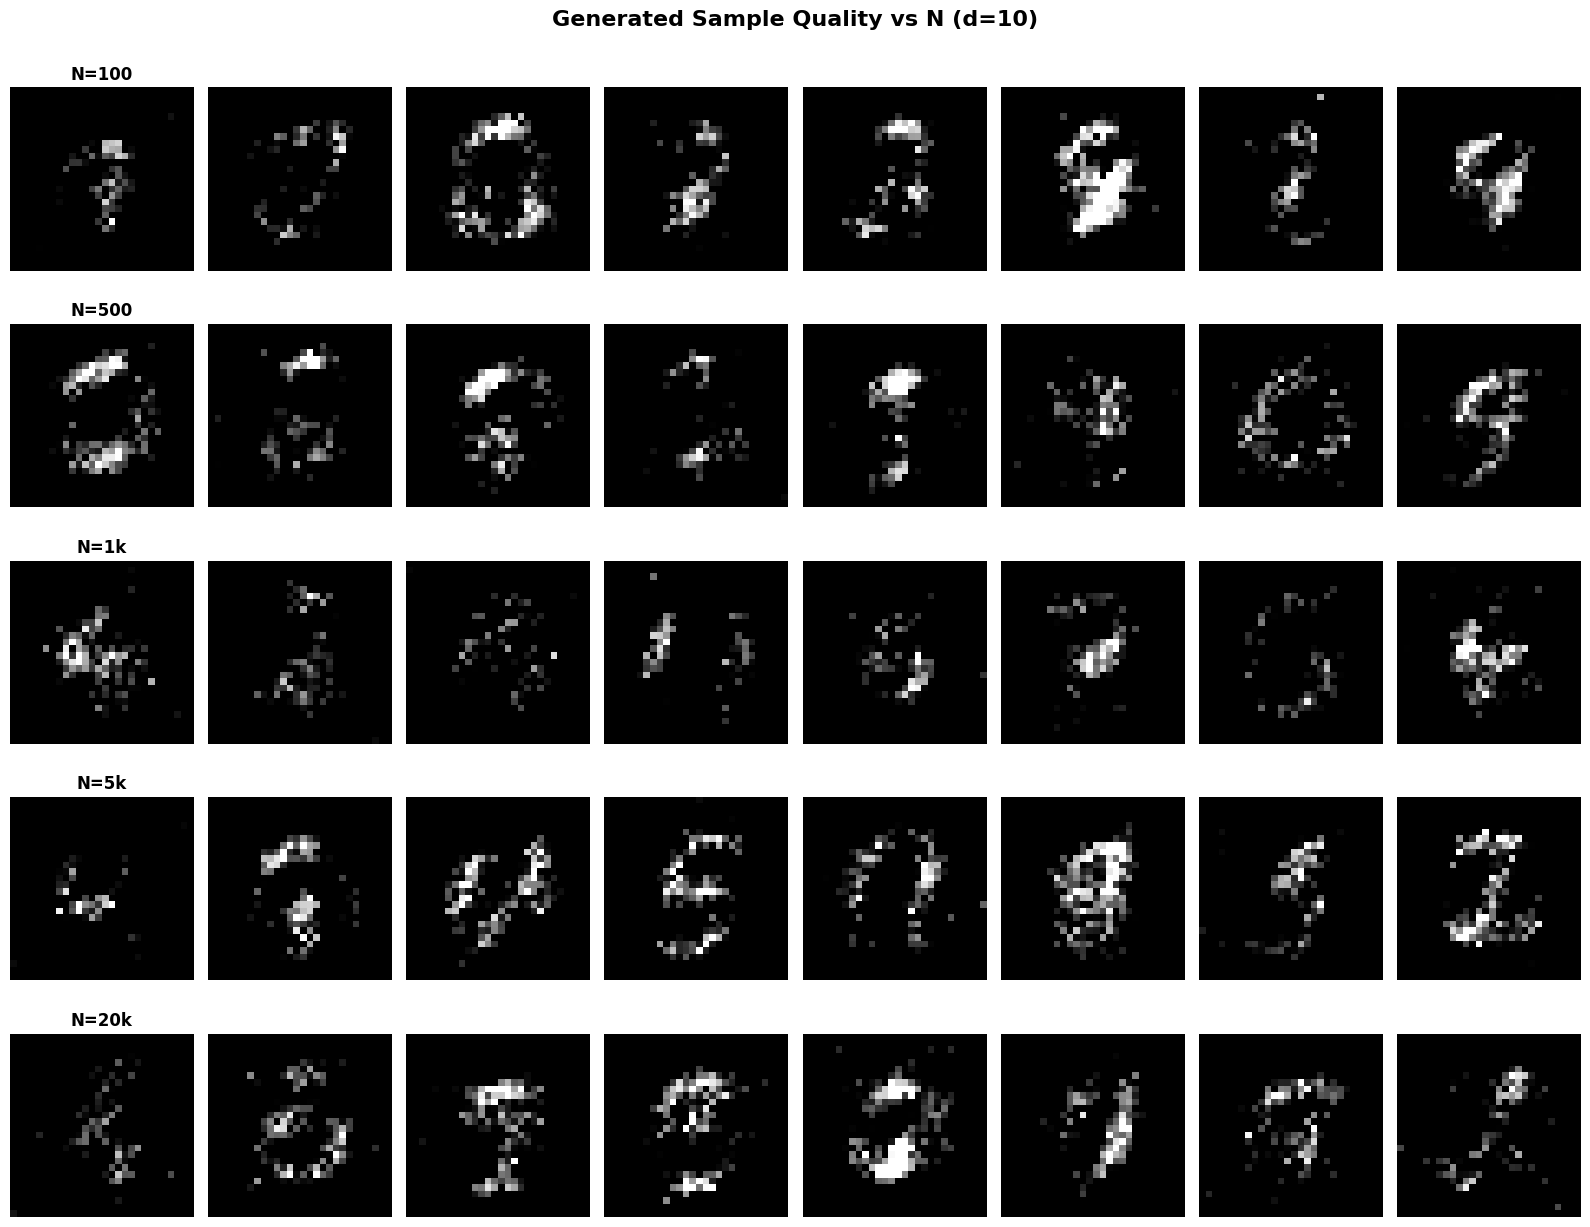


Summary Table
      N     N/d     Final LL      b Err  W Err (°)      σ Err    Recon Err
--------------------------------------------------------------------------------
    100    10.0    -29619.02   0.068864    68.7875   0.082493     0.115942
    200    20.0    -64923.79   0.031353    43.6937   0.047154     0.126738
    500    50.0   -173558.62   0.034918    22.8502   0.019015     0.133665
   1000   100.0   -356707.22   0.015633    18.9025   0.006428     0.135282
   5000   500.0  -1798725.62   0.008255    13.2599   0.002446     0.137330
  10000  1000.0  -3590326.25   0.006959     7.3509   0.003357     0.142150
  20000  2000.0  -7234562.50   0.003444     4.0736   0.000097     0.129850


In [65]:
## Part (g): Effect of sample size N - Implementation

print("=" * 80)
print("Part (g): Effect of Sample Size N")
print("=" * 80)

# Fix latent dimension
d_fixed = 10
print(f"\nFixed latent dimension: d = {d_fixed}")

# Test different sample sizes
sample_sizes = [100, 200, 500, 1000, 5000, 10000, 20000]
n_em_iters = 50
n_samples_viz = 8

# Store results for each sample size
results_by_N = {}

# Get reference solution (full dataset)
print(f"\n{'=' * 80}")
print(f"Computing REFERENCE solution (full dataset, N={X.shape[0]})")
print(f"{'=' * 80}")
W_ref, b_ref, sigma_ref = closed_form_ppca(X, d_fixed)
ll_ref = log_likelihood(X, b_ref, W_ref, sigma_ref)
print(f"Reference log-likelihood: {ll_ref:.2f}")
print(f"Reference σ: {sigma_ref:.4f}")

for N in sample_sizes:
    print(f"\n{'=' * 80}")
    print(f"Training PPCA with N = {N} samples (d = {d_fixed})")
    print(f"{'=' * 80}")
    
    # Sample N data points
    indices = np.random.choice(X.shape[0], min(N, X.shape[0]), replace=False)
    X_subset = X[indices]
    
    # Initialize EM
    b_k = torch.zeros(data_dim)
    W_k = torch.eye(data_dim)[:, :d_fixed].contiguous()
    sigma_k = torch.tensor(0.1)
    
    # Track convergence
    ll_history = []
    b_err_history = []
    W_subspace_err_history = []
    sigma_err_history = []
    
    # Run EM
    for k in range(n_em_iters):
        # E-step
        Ez, EzzT = estep_posterior_moments(X_subset, b_k, W_k, sigma_k)
        
        # M-step
        b_k, W_k, sigma_k = mstep_update(X_subset, Ez, EzzT)
        
        # Track metrics
        ll = log_likelihood(X_subset, b_k, W_k, sigma_k)
        ll_history.append(float(ll))
        
        # Errors relative to reference
        b_err = float(torch.norm(b_k - b_ref) / (torch.norm(b_ref) + 1e-12))
        b_err_history.append(b_err)
        
        # Subspace error
        W_err = subspace_error(W_k, W_ref)
        W_subspace_err_history.append(W_err)
        
        sigma_err = float(torch.abs(sigma_k - sigma_ref) / (torch.abs(sigma_ref) + 1e-12))
        sigma_err_history.append(sigma_err)
    
    # Generate samples
    samples_N = sample_from_ppca(W_k, b_k, sigma_k, n_samples=n_samples_viz)
    
    # Compute reconstruction error
    if N >= 10:
        test_size = min(100, N)
        test_indices = np.random.choice(N, test_size, replace=False)
        X_test_N = X_subset[test_indices]
        
        WtW = W_k.T @ W_k
        sigma_sq = sigma_k**2
        posterior_cov_inv = WtW + sigma_sq * torch.eye(d_fixed)
        X_centered = X_test_N - b_k.unsqueeze(0)
        z_posterior = X_centered @ W_k @ torch.linalg.inv(posterior_cov_inv)
        X_recon_N = z_posterior @ W_k.T + b_k.unsqueeze(0)
        recon_error = float(torch.mean((X_test_N - X_recon_N)**2))
    else:
        recon_error = float('nan')
    
    # Store results
    results_by_N[N] = {
        'W': W_k.clone(),
        'b': b_k.clone(),
        'sigma': sigma_k.clone(),
        'll_history': ll_history,
        'b_err_history': b_err_history,
        'W_subspace_err_history': W_subspace_err_history,
        'sigma_err_history': sigma_err_history,
        'final_ll': ll_history[-1],
        'final_b_err': b_err_history[-1],
        'final_W_err': W_subspace_err_history[-1],
        'final_sigma_err': sigma_err_history[-1],
        'samples': samples_N,
        'recon_error': recon_error
    }
    
    print(f"  Final log-likelihood: {ll_history[-1]:.2f}")
    print(f"  Final b error: {b_err_history[-1]:.6f}")
    print(f"  Final W subspace error: {W_subspace_err_history[-1]:.4f}°")
    print(f"  Final σ error: {sigma_err_history[-1]:.6f}")
    print(f"  Estimated σ: {sigma_k:.4f}")
    if not np.isnan(recon_error):
        print(f"  Reconstruction error: {recon_error:.6f}")

# Visualization 1: Convergence curves
print("\n" + "=" * 80)
print("Generating Convergence Plots")
print("=" * 80)

fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))

# Plot log-likelihood convergence
for N in sample_sizes:
    ll_hist = results_by_N[N]['ll_history']
    label = f'N={N}' if N < 1000 else f'N={N//1000}k'
    axes1[0, 0].plot(ll_hist, label=label, linewidth=2, alpha=0.8)
axes1[0, 0].set_xlabel('EM Iteration', fontsize=12)
axes1[0, 0].set_ylabel('Log-likelihood', fontsize=12)
axes1[0, 0].set_title('Log-likelihood Convergence', fontsize=14, fontweight='bold')
axes1[0, 0].legend(fontsize=8, ncol=2)
axes1[0, 0].grid(True, alpha=0.3)

# Plot b error convergence
for N in sample_sizes:
    b_err_hist = results_by_N[N]['b_err_history']
    label = f'N={N}' if N < 1000 else f'N={N//1000}k'
    axes1[0, 1].plot(b_err_hist, label=label, linewidth=2, alpha=0.8)
axes1[0, 1].set_xlabel('EM Iteration', fontsize=12)
axes1[0, 1].set_ylabel('Relative Error', fontsize=12)
axes1[0, 1].set_title('b Parameter Error vs Reference', fontsize=14, fontweight='bold')
axes1[0, 1].legend(fontsize=8, ncol=2)
axes1[0, 1].grid(True, alpha=0.3)
axes1[0, 1].set_yscale('log')

# Plot W subspace error convergence
for N in sample_sizes:
    W_err_hist = results_by_N[N]['W_subspace_err_history']
    label = f'N={N}' if N < 1000 else f'N={N//1000}k'
    axes1[1, 0].plot(W_err_hist, label=label, linewidth=2, alpha=0.8)
axes1[1, 0].set_xlabel('EM Iteration', fontsize=12)
axes1[1, 0].set_ylabel('Subspace Error (degrees)', fontsize=12)
axes1[1, 0].set_title('W Subspace Error vs Reference', fontsize=14, fontweight='bold')
axes1[1, 0].legend(fontsize=8, ncol=2)
axes1[1, 0].grid(True, alpha=0.3)

# Plot sigma error convergence
for N in sample_sizes:
    sigma_err_hist = results_by_N[N]['sigma_err_history']
    label = f'N={N}' if N < 1000 else f'N={N//1000}k'
    axes1[1, 1].plot(sigma_err_hist, label=label, linewidth=2, alpha=0.8)
axes1[1, 1].set_xlabel('EM Iteration', fontsize=12)
axes1[1, 1].set_ylabel('Relative Error', fontsize=12)
axes1[1, 1].set_title('σ Parameter Error vs Reference', fontsize=14, fontweight='bold')
axes1[1, 1].legend(fontsize=8, ncol=2)
axes1[1, 1].grid(True, alpha=0.3)
axes1[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

# Visualization 2: Final metrics vs N
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))

# Final errors vs N
b_errs = [results_by_N[N]['final_b_err'] for N in sample_sizes]
axes2[0, 0].semilogx(sample_sizes, b_errs, 'o-', linewidth=2, markersize=8, color='blue')
axes2[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes2[0, 0].set_xlabel('Sample Size N', fontsize=12)
axes2[0, 0].set_ylabel('b Relative Error', fontsize=12)
axes2[0, 0].set_title('b Error vs Sample Size', fontsize=14, fontweight='bold')
axes2[0, 0].grid(True, alpha=0.3)

W_errs = [results_by_N[N]['final_W_err'] for N in sample_sizes]
axes2[0, 1].semilogx(sample_sizes, W_errs, 'o-', linewidth=2, markersize=8, color='green')
axes2[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes2[0, 1].set_xlabel('Sample Size N', fontsize=12)
axes2[0, 1].set_ylabel('W Subspace Error (degrees)', fontsize=12)
axes2[0, 1].set_title('W Subspace Error vs Sample Size', fontsize=14, fontweight='bold')
axes2[0, 1].grid(True, alpha=0.3)

sigma_errs = [results_by_N[N]['final_sigma_err'] for N in sample_sizes]
axes2[1, 0].semilogx(sample_sizes, sigma_errs, 'o-', linewidth=2, markersize=8, color='purple')
axes2[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes2[1, 0].set_xlabel('Sample Size N', fontsize=12)
axes2[1, 0].set_ylabel('σ Relative Error', fontsize=12)
axes2[1, 0].set_title('σ Error vs Sample Size', fontsize=14, fontweight='bold')
axes2[1, 0].grid(True, alpha=0.3)

# Reconstruction error vs N
recon_errs = [results_by_N[N]['recon_error'] for N in sample_sizes]
# Filter out NaN values
valid_N = [N for N, err in zip(sample_sizes, recon_errs) if not np.isnan(err)]
valid_errs = [err for err in recon_errs if not np.isnan(err)]
axes2[1, 1].semilogx(valid_N, valid_errs, 'o-', linewidth=2, markersize=8, color='red')
axes2[1, 1].set_xlabel('Sample Size N', fontsize=12)
axes2[1, 1].set_ylabel('Reconstruction Error (MSE)', fontsize=12)
axes2[1, 1].set_title('Reconstruction Error vs Sample Size', fontsize=14, fontweight='bold')
axes2[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualization 3: Sample quality comparison
selected_Ns = [100, 500, 1000, 5000, 20000]
fig3, axes3 = plt.subplots(len(selected_Ns), n_samples_viz, 
                           figsize=(16, 2.5 * len(selected_Ns)))

for i, N in enumerate(selected_Ns):
    samples = results_by_N[N]['samples']
    
    for j in range(n_samples_viz):
        img = np.clip(samples[j].reshape(28, 28).numpy(), 0, 1)
        axes3[i, j].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes3[i, j].axis('off')
        
        if j == 0:
            label = f'N={N}' if N < 1000 else f'N={N//1000}k'
            axes3[i, j].set_title(label, fontsize=12, fontweight='bold')

plt.suptitle(f'Generated Sample Quality vs N (d={d_fixed})', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 80)
print("Summary Table")
print("=" * 80)
print(f"{'N':>7} {'N/d':>7} {'Final LL':>12} {'b Err':>10} {'W Err (°)':>10} {'σ Err':>10} {'Recon Err':>12}")
print("-" * 80)
for N in sample_sizes:
    ratio = N / d_fixed
    ll = results_by_N[N]['final_ll']
    b_err = results_by_N[N]['final_b_err']
    W_err = results_by_N[N]['final_W_err']
    sigma_err = results_by_N[N]['final_sigma_err']
    recon = results_by_N[N]['recon_error']
    
    if np.isnan(recon):
        print(f"{N:>7} {ratio:>7.1f} {ll:>12.2f} {b_err:>10.6f} {W_err:>10.4f} {sigma_err:>10.6f} {'N/A':>12}")
    else:
        print(f"{N:>7} {ratio:>7.1f} {ll:>12.2f} {b_err:>10.6f} {W_err:>10.4f} {sigma_err:>10.6f} {recon:>12.6f}")

As sample size increases, all error metrics systematically decrease, showing that more data leads to better parameter estimation and convergence to the true model. The W subspace error exhibits particularly dramatic improvement with larger sample sizes, indicating that the learned principal subspace becomes increasingly aligned with the reference solution. Convergence behavior becomes smoother and more stable with more samples, while smaller sample sizes show more erratic trajectories during EM iterations. There's a clear pattern of diminishing returns - doubling the sample size from small to medium values yields much larger improvements than similar doublings at higher sample sizes. Generated sample quality tracks these trends closely, with blurry, inconsistent digits at small N gradually transitioning to clearer, more recognizable digits as the number of training samples grows substantially beyond the latent dimension.

## Part (h)
Suppose now we move into a two/three-class regime, by adding classes to the \texttt{CLASSES} list. What do you observe about the sample mean and covariance? Based on the data samples we have, do the images generated make sense? What assumptions should we modify so it can improve the quality of our generation, or perhaps handle even more classes?

Part (h): Effect of Number of Classes

Configuration: Single class (0)
Number of samples: 5923
  Mean variance: 0.229235
  Total data variance: 199.68
  Effective rank (95% variance): 116
  Estimated σ: 0.3105

Configuration: Two classes (0, 1)
Number of samples: 12665
  Mean variance: 0.110039
  Total data variance: 198.19
  Effective rank (95% variance): 1
  Estimated σ: 0.2929

Configuration: Three classes (0, 1, 2)
Number of samples: 18623
  Mean variance: 0.112840
  Total data variance: 212.11
  Effective rank (95% variance): 126
  Estimated σ: 0.3286

Configuration: Five classes (0-4)
Number of samples: 30596
  Mean variance: 0.107428
  Total data variance: 215.40
  Effective rank (95% variance): 140
  Estimated σ: 0.3563

Configuration: All classes (0-9)
Number of samples: 60000
  Mean variance: 0.110858
  Total data variance: 210.90
  Effective rank (95% variance): 154
  Estimated σ: 0.3735

Visualizing Sample Means and Covariances


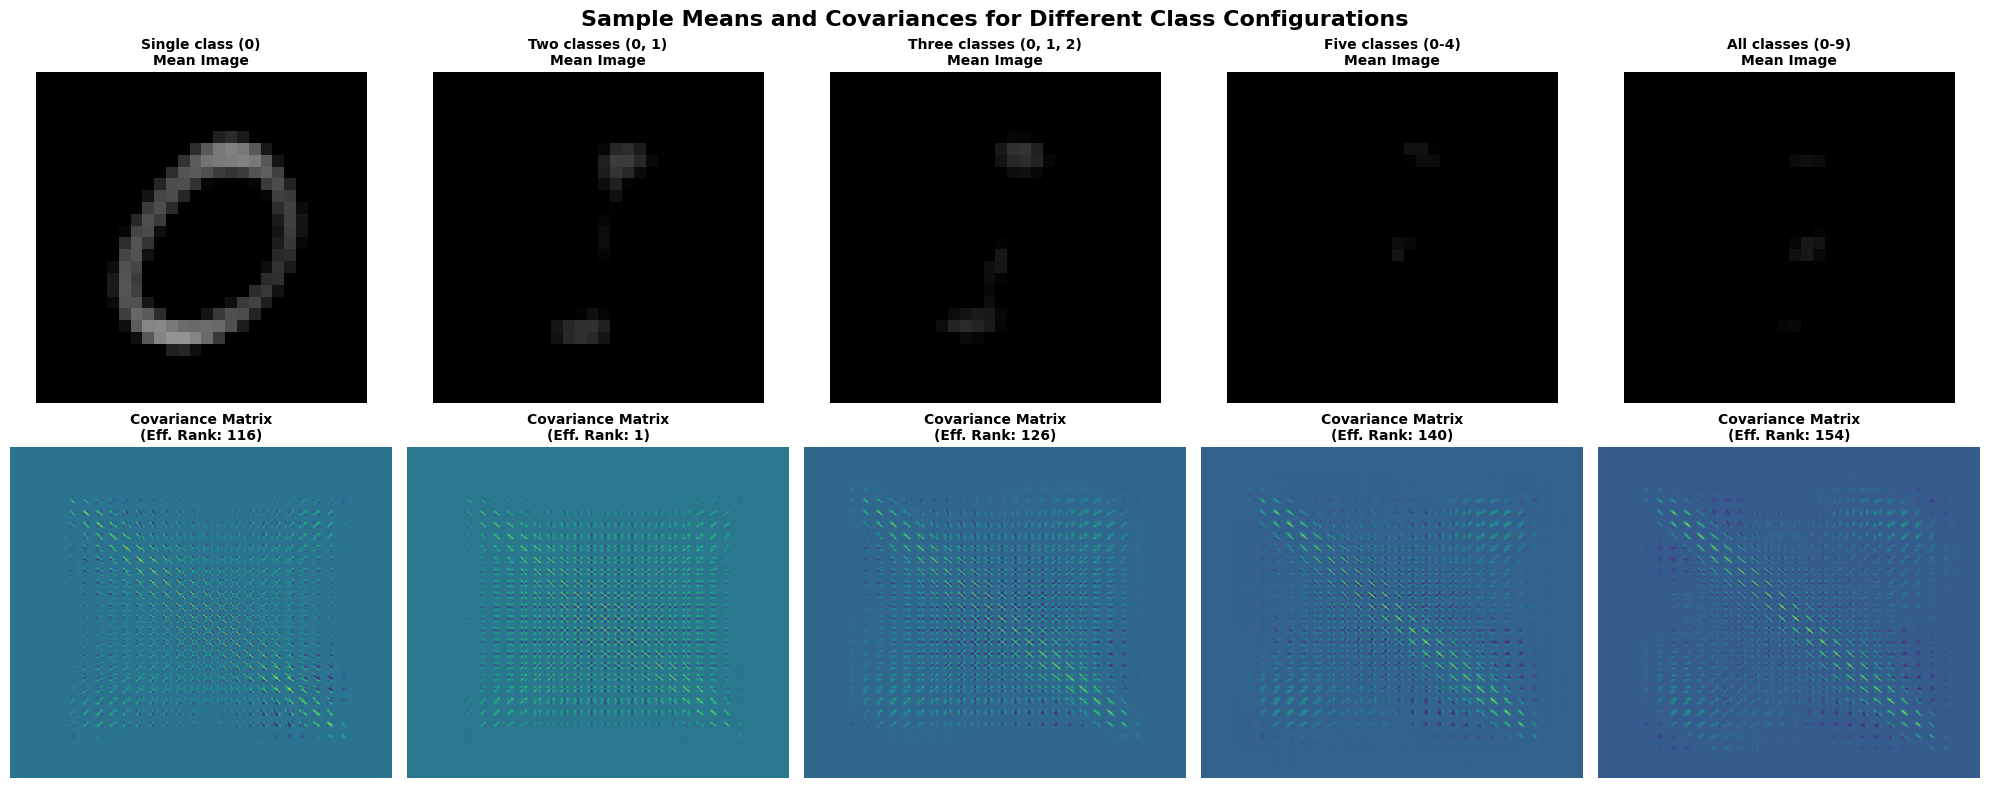

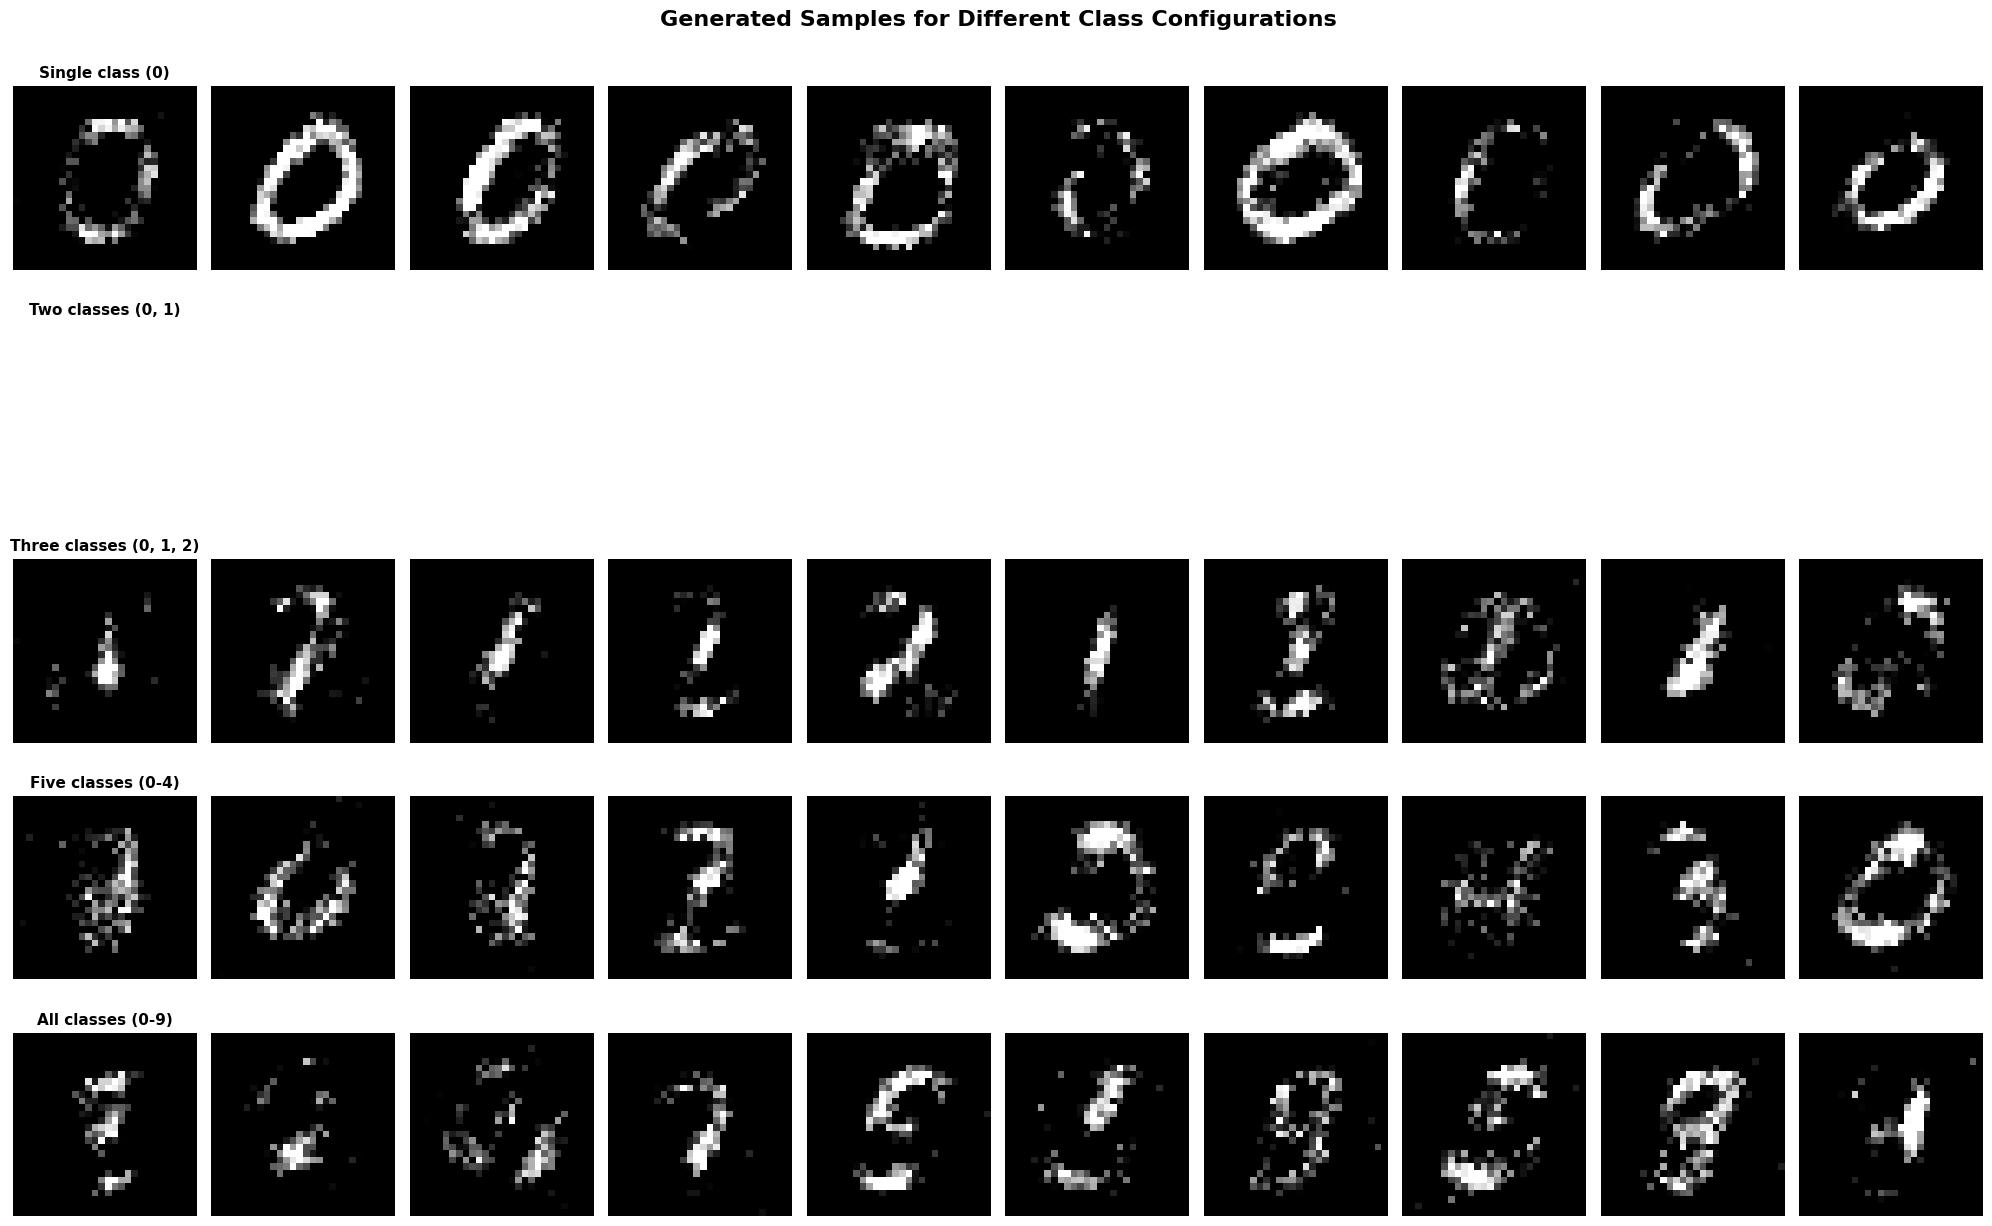

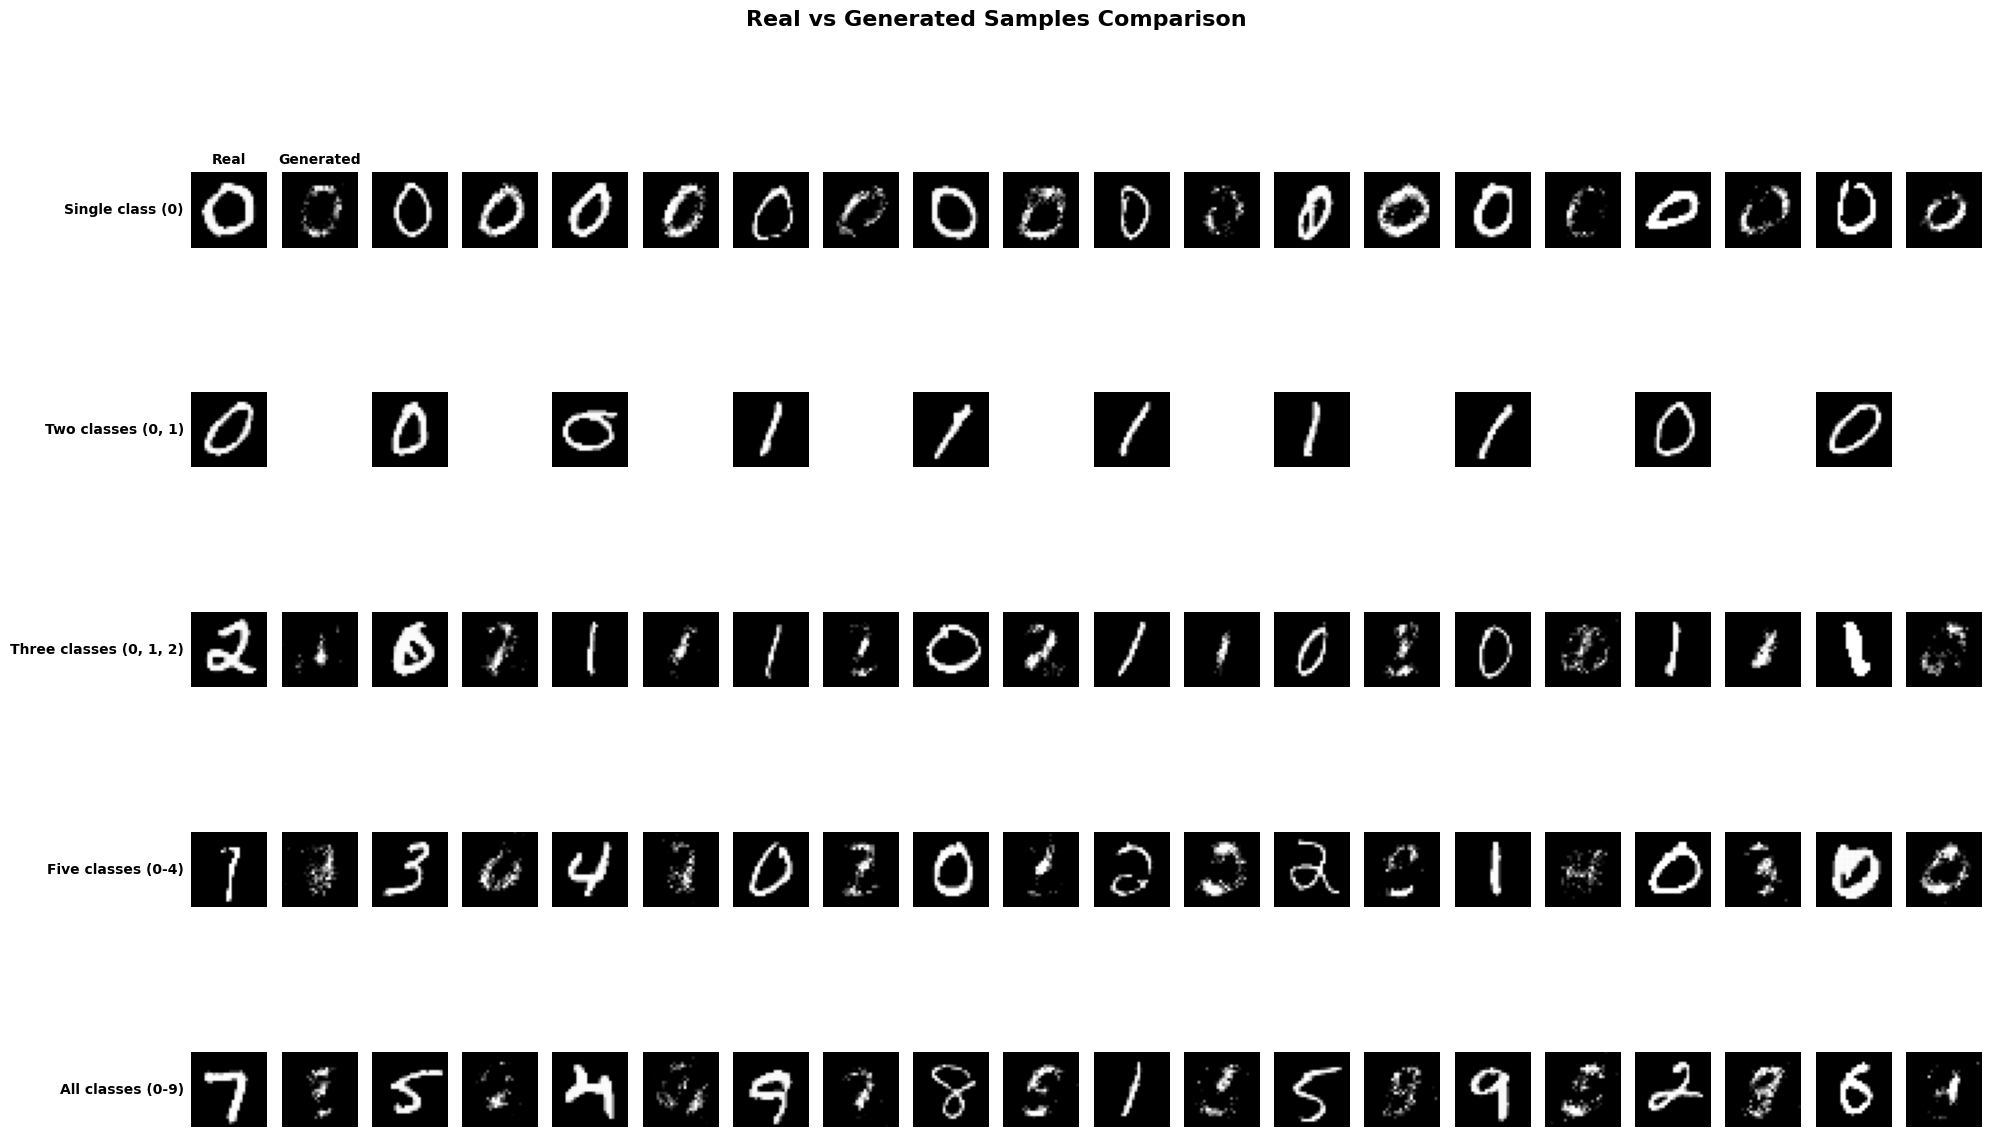

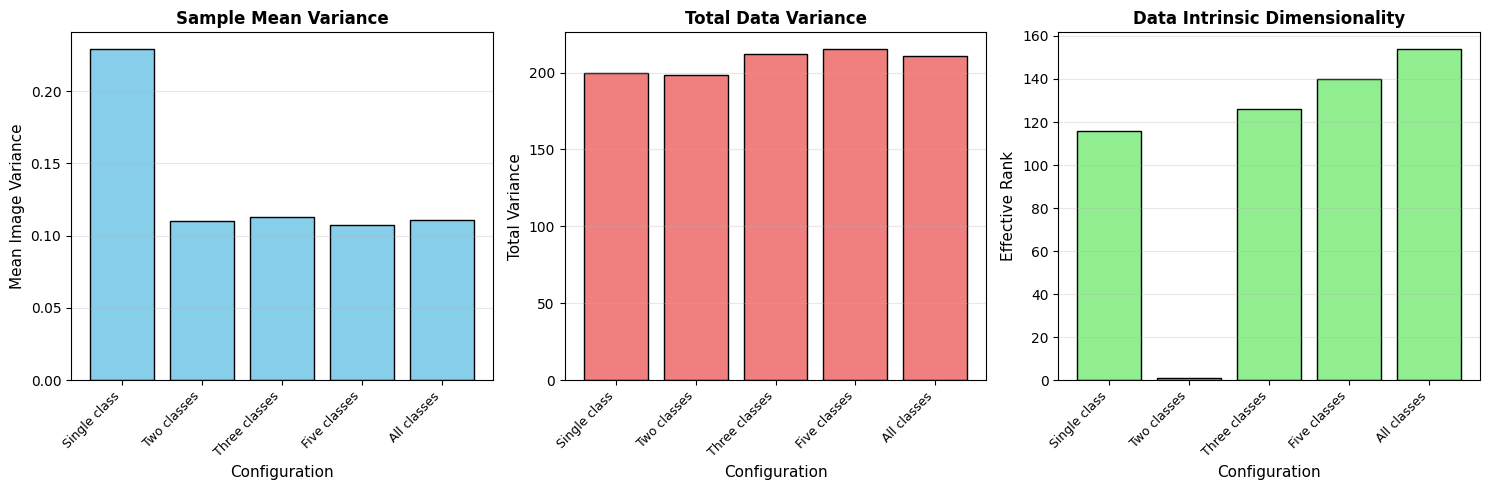


Summary Table
Configuration                        N   Mean Var    Total Var   Eff Rank        σ
--------------------------------------------------------------------------------
Single class (0)                  5923   0.229235       199.68        116   0.3105
Two classes (0, 1)               12665   0.110039       198.19          1   0.2929
Three classes (0, 1, 2)          18623   0.112840       212.11        126   0.3286
Five classes (0-4)               30596   0.107428       215.40        140   0.3563
All classes (0-9)                60000   0.110858       210.90        154   0.3735


In [67]:
## Part (h): Multi-class Analysis - Implementation

print("=" * 80)
print("Part (h): Effect of Number of Classes")
print("=" * 80)

# Define different class configurations
class_configs = {
    'Single class (0)': [0],
    'Two classes (0, 1)': [0, 1],
    'Three classes (0, 1, 2)': [0, 1, 2],
    'Five classes (0-4)': [0, 1, 2, 3, 4],
    'All classes (0-9)': list(range(10))
}

latent_dim_h = 10
n_samples_viz = 10
results_by_classes = {}

for config_name, classes in class_configs.items():
    print(f"\n{'=' * 80}")
    print(f"Configuration: {config_name}")
    print(f"{'=' * 80}")
    
    # Filter data for these classes
    X_config = filter_classes_or_individuals(classes)
    print(f"Number of samples: {X_config.shape[0]}")
    
    # Compute sample mean and covariance
    mean_config, cov_config = compute_sample_mean_cov(X_config)
    
    # Train closed-form PPCA
    W_config, b_config, sigma_config = closed_form_ppca(X_config, latent_dim_h)
    
    # Generate samples
    samples_config = sample_from_ppca(W_config, b_config, sigma_config, n_samples=n_samples_viz)
    
    # Compute some statistics
    # Variance of mean across pixels (how "concentrated" is the mean image)
    mean_variance = float(torch.var(mean_config))
    
    # Trace of covariance (total variance in data)
    total_variance = float(torch.trace(cov_config))
    
    # Effective rank of covariance (number of significant dimensions)
    eigenvalues_cov = torch.linalg.eigvalsh(cov_config)
    eigenvalues_cov = torch.sort(eigenvalues_cov, descending=True)[0]
    # Effective rank: number of eigenvalues needed to capture 95% variance
    cumsum = torch.cumsum(eigenvalues_cov, dim=0)
    total_var = cumsum[-1]
    eff_rank = int(torch.sum(cumsum < 0.95 * total_var)) + 1
    
    results_by_classes[config_name] = {
        'classes': classes,
        'n_samples': X_config.shape[0],
        'mean': mean_config,
        'cov': cov_config,
        'W': W_config,
        'b': b_config,
        'sigma': sigma_config,
        'samples': samples_config,
        'mean_variance': mean_variance,
        'total_variance': total_variance,
        'effective_rank': eff_rank
    }
    
    print(f"  Mean variance: {mean_variance:.6f}")
    print(f"  Total data variance: {total_variance:.2f}")
    print(f"  Effective rank (95% variance): {eff_rank}")
    print(f"  Estimated σ: {sigma_config:.4f}")

# Visualization 1: Sample means for different class configurations
print("\n" + "=" * 80)
print("Visualizing Sample Means and Covariances")
print("=" * 80)

fig1, axes1 = plt.subplots(2, len(class_configs), figsize=(20, 8))

for i, (config_name, result) in enumerate(results_by_classes.items()):
    # Plot mean
    mean_img = result['mean'].reshape(28, 28).numpy()
    axes1[0, i].imshow(mean_img, cmap='gray', vmin=0, vmax=1)
    axes1[0, i].set_title(f'{config_name}\nMean Image', fontsize=10, fontweight='bold')
    axes1[0, i].axis('off')
    
    # Plot covariance (downsampled for visualization)
    cov_img = result['cov'].numpy()
    axes1[1, i].imshow(cov_img, cmap='viridis', aspect='auto')
    axes1[1, i].set_title(f'Covariance Matrix\n(Eff. Rank: {result["effective_rank"]})', 
                         fontsize=10, fontweight='bold')
    axes1[1, i].axis('off')

plt.suptitle('Sample Means and Covariances for Different Class Configurations', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Visualization 2: Generated samples for each configuration
fig2, axes2 = plt.subplots(len(class_configs), n_samples_viz, 
                           figsize=(20, 2.5 * len(class_configs)))

for i, (config_name, result) in enumerate(results_by_classes.items()):
    samples = result['samples']
    
    for j in range(n_samples_viz):
        img = np.clip(samples[j].reshape(28, 28).numpy(), 0, 1)
        axes2[i, j].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes2[i, j].axis('off')
        
        if j == 0:
            axes2[i, j].set_title(config_name, fontsize=11, fontweight='bold')

plt.suptitle('Generated Samples for Different Class Configurations', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

# Visualization 3: Real samples vs Generated samples comparison
fig3, axes3 = plt.subplots(len(class_configs), 2 * n_samples_viz, 
                           figsize=(20, 2.5 * len(class_configs)))

for i, (config_name, result) in enumerate(results_by_classes.items()):
    # Get corresponding data
    X_config = filter_classes_or_individuals(result['classes'])
    
    # Random real samples
    real_indices = np.random.choice(X_config.shape[0], n_samples_viz, replace=False)
    
    for j in range(n_samples_viz):
        # Real sample
        real_img = X_config[real_indices[j]].reshape(28, 28).numpy()
        axes3[i, 2*j].imshow(real_img, cmap='gray', vmin=0, vmax=1)
        axes3[i, 2*j].axis('off')
        if i == 0 and j == 0:
            axes3[i, 2*j].set_title('Real', fontsize=10, fontweight='bold')
        
        # Generated sample
        gen_img = np.clip(result['samples'][j].reshape(28, 28).numpy(), 0, 1)
        axes3[i, 2*j + 1].imshow(gen_img, cmap='gray', vmin=0, vmax=1)
        axes3[i, 2*j + 1].axis('off')
        if i == 0 and j == 0:
            axes3[i, 2*j + 1].set_title('Generated', fontsize=10, fontweight='bold')
        
        if j == 0:
            axes3[i, 0].text(-0.1, 0.5, config_name, transform=axes3[i, 0].transAxes,
                           fontsize=10, fontweight='bold', va='center', ha='right', rotation=0)

plt.suptitle('Real vs Generated Samples Comparison', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

# Visualization 4: Statistics comparison
fig4, axes4 = plt.subplots(1, 3, figsize=(15, 5))

config_names_short = [name.split('(')[0].strip() for name in class_configs.keys()]
mean_vars = [results_by_classes[name]['mean_variance'] for name in class_configs.keys()]
total_vars = [results_by_classes[name]['total_variance'] for name in class_configs.keys()]
eff_ranks = [results_by_classes[name]['effective_rank'] for name in class_configs.keys()]
sigmas = [float(results_by_classes[name]['sigma']) for name in class_configs.keys()]

x_pos = np.arange(len(config_names_short))

# Mean variance
axes4[0].bar(x_pos, mean_vars, color='skyblue', edgecolor='black')
axes4[0].set_xlabel('Configuration', fontsize=11)
axes4[0].set_ylabel('Mean Image Variance', fontsize=11)
axes4[0].set_title('Sample Mean Variance', fontsize=12, fontweight='bold')
axes4[0].set_xticks(x_pos)
axes4[0].set_xticklabels(config_names_short, rotation=45, ha='right', fontsize=9)
axes4[0].grid(True, alpha=0.3, axis='y')

# Total variance
axes4[1].bar(x_pos, total_vars, color='lightcoral', edgecolor='black')
axes4[1].set_xlabel('Configuration', fontsize=11)
axes4[1].set_ylabel('Total Variance', fontsize=11)
axes4[1].set_title('Total Data Variance', fontsize=12, fontweight='bold')
axes4[1].set_xticks(x_pos)
axes4[1].set_xticklabels(config_names_short, rotation=45, ha='right', fontsize=9)
axes4[1].grid(True, alpha=0.3, axis='y')

# Effective rank
axes4[2].bar(x_pos, eff_ranks, color='lightgreen', edgecolor='black')
axes4[2].set_xlabel('Configuration', fontsize=11)
axes4[2].set_ylabel('Effective Rank', fontsize=11)
axes4[2].set_title('Data Intrinsic Dimensionality', fontsize=12, fontweight='bold')
axes4[2].set_xticks(x_pos)
axes4[2].set_xticklabels(config_names_short, rotation=45, ha='right', fontsize=9)
axes4[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 80)
print("Summary Table")
print("=" * 80)
print(f"{'Configuration':<30} {'N':>7} {'Mean Var':>10} {'Total Var':>12} {'Eff Rank':>10} {'σ':>8}")
print("-" * 80)
for config_name, result in results_by_classes.items():
    print(f"{config_name:<30} {result['n_samples']:>7} {result['mean_variance']:>10.6f} "
          f"{result['total_variance']:>12.2f} {result['effective_rank']:>10} {float(result['sigma']):>8.4f}")

As more digit classes are included, the sample mean image becomes increasingly blurry and loses recognizable structure because it averages across fundamentally different digit shapes, while the covariance structure becomes more complex with higher effective rank reflecting the multi-modal nature of the data. The generated samples progressively deteriorate from clear digit variations (single class) to unrecognizable blurry blobs (all classes) that look like averages between different digits rather than actual digits. This failure occurs because PPCA's fundamental assumption of a single Gaussian distribution is violated when data contains multiple distinct digit classes, each representing a different mode in the distribution. To handle multiple classes effectively, we need to replace the single-Gaussian assumption with either a mixture model approach (like Mixture of PPCA or GMM) where each class gets its own Gaussian component, or use class-conditional models that train separate PPCA models per digit class. Alternatively, more expressive non-linear models like Variational Autoencoders could capture the complex multi-modal structure without requiring explicit class labels.